<a href="https://www.kaggle.com/code/ccncay/two-in-one-cancer-classification-and-metaanalysis?scriptVersionId=181554197" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# The two in one analysis: a distance-based approach to classification of leukemias, and a metaanalysis of previous models


## by Peter Horvath 

## kaggle ID / github ID: CCNCAY

### 05-06-2024 version 1.0

# Preface for readers outside of Kaggle community. 

This is the author's personal remark and introduction to those readers arriving from outside of Kaggle (i.e. from the author's own social network). Welcome. Kaggle is a community and website for data analysis / machine learning hobbyists and professionals at any levels of expertise. The site supports and encourages its members to develop their skills in data analysis, by posting data mining and machine learning challenges to work on. 
One famous data set is known as the "Gene expression dataset (Golub et al.)" which is based on a published paper https://pubmed.ncbi.nlm.nih.gov/10521349/

The goal of the original Golub et al. (1999) paper was to develop a classification method that can differentiate between two types of leukemia, acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL), based on Affymetrix gene expression chip data. Golub et al. used their novel method to identify 50 genes of which expression levels can be used as a molecular diagnostic tool to differentiate between ALL and AML. 

The author of the work presented here walks the same path many people walked before him, by creating his own classification model from the dataset. As a geneticist expert and aspiring data analyst, the author believes he managed to add some unique touches to the problem.
# 

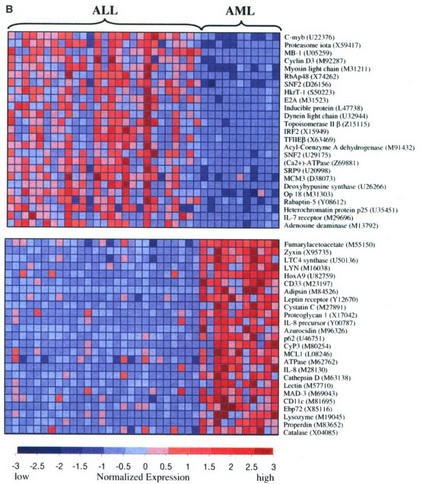

Figure from Golub et al. 

***

# INTRODUCTION


The Golube et. al. dataset is a well known training ground to kaggle community: in short, this is a biological dataset from patients diagnosed with either of two following types of leukemia: acute myeloid leukemia (AML) or acute lymphoblastic leukemia (ALL). The goal is to establish a machine learning method or model that can tell apart ALL from AML using the dataset. There are numerous solutions to the problem and even some publications were created based on this work. However, most of the works do not look behind the curtain in the biological sense. *From a data analysis perspective* it is perhaps not necessary to do so, but as a geneticist, the author of this work argues that it is worthwhile to deeply understand not only the dataset itself, but what it means and what the implications of the models may be. 

A model does not only exist as a standalone object in its own universe, but it may be and should be cross-checked, cross-referenced to works of others. In this work a working concept is implemented to solve the AML/ALL problem, as well the results are compared with those published their work on kaggle. An additional minor goal is to make this work understandable to non-experts, by explaining concepts and chain of thoughts that might be obvious for most kaggle members. 


***

# UNDERSTANDING THE DATA

The core of the original dataset consists of 72 patients, each is diagnosed with either ALL or AML. Each patient is represented by a number. The patients are the columns of the dataset:

                                                                                                                               Patients: 

|1|2|3|4|etc...|
|-|-|-|-|-|
|. . .
                     
                      
                      

Biological samples from each patients were analyzed using the Affymetrix Hu6800 RNA chip. The RNA chip analyses gene expression levels from the samples. The chip contains roughly 6800 human genes, along with duplicates and controls, it has a total number of more than 7100 individual data points ("reads") for each patients. The gene reads are represented by a number, that is a raw fluorescence readout from the machine. The number corresponds to the given gene activity in the patient. The database therefore looks more like this:

                                                                                                                Patients and gene expression data: 

|index|gene name|gene ID|1|2|3|4|...|
|-|-|-|-|-|-|-|-|
|0|GeneFoo|A0000|1531|31|-50|4899|. . .|
|1|GeneBar|B0012|15899|231|2113|6|. . .|
|. . .


On top of the raw data, each gene expression has a "call" value. That is a single-letter code added by the chip reader software that helps understanding if the data is reliable or not. The reason for this is that each measurement involving fluorescent reads, suffer from various levels of noise, coming from the background noise of the machine, the chemicals, the sample processing and the inevitable biological variance. Therefore any raw data, below a certain threshold, is inadmissible. This system has 3 codes, P for presence, A for absence, and M for marginal presence - i.e. the presence that just slightly made the bar. So the representation of the data, when the calls are also added looks like this:


                                                                                                            Patients and gene expression data with calls: 

|index|gene name|gene ID|1|call.1|2|call.2|3|call.3|4|call.4|...|
|-----|---------|-------|-|-----|-|-----|-|-----|-|-----|-|
|0|GeneFoo|A0000|1531|P|31|A|-50|A|4899|P|. . .|
|1|GeneBar|B0012|15899|P|231|M|2113|P|6|A|. . .|
|. . .


In a separate file, all patients are paired with their diagnosis group, such as patient1 = AML, patient2 = ALL, patientX = xxx. Furthermore, the dataset is already split into training and testing sub-datasets. 

***

# METHODS

In this work two different approaches were used to create models from the dataset. The first steps of the two appraoches overlap. Some of the decisions are arbitrary and based on the author's preexisting experience as geneticist and gene regulation expert. 

## Step 1: cleaning up and transforming the dataset. 

After importing and transforming the two datasets into Pandas dataframes, the following preparation steps were done.

1. Uncertain reads were not used. During data processing all values with either "A" (absent) or "M" (marginal) calls were replaced by 0. Method: 
- Step 1, the calls were replaced in the database P =>  1, A => 0 and M => 0; and then 
- the corresponding values in neighbor columns were multiplied by this number. Hence the values next to P's were unchanged but the non-P's were set to 0. An example of the processed data would look like (from above):


                                                                                                   Patients and gene expression data with calls, after cleaning: 

|index|gene name|gene ID|1|call.1|2|call.2|3|call.3|4|call.4|...|
|-----|---------|-------|-|-----|-|-----|-|-----|-|-----|-|
|0|GeneFoo|A0000|1531|M|**0**|A|**0**|A|4899|P|. . .|
|1|GeneBar|B0012|15899|P|**0**|M|2113|P|**0**|A|. . .|
|. . .

2. What is usually interesting in gene expression pattern is the ratio, rather than the arithmetic difference between two values.
- The reason is that genes work on a concentration basis and hance are sensitive to ratios. 
- The normal (i.e. phsyological average) amount of gene product can differ from a few per cell to millions per cell. 
- The raw value of the read corresponds to the levels of gene expression, but it has a narrower dynamic range than the gene expression itself. Therefore, extremely low values are lost to reading thresholds, and extremely high values may or may not be capped and squeezed together at the upper reading limit. 
- Despite the limitations, reads will be considered linear if the call value is P (present). 
- A main decision of this work was to use this knowledge when building up the models, and manually encode the usage of the ratios into the model rather than applying a naive approach and letting it figure it out.


3. Because of the use of ratios, a baseline is needed to replace 0 values to avoid zero-division without losing datapoints. Considerations:
- Affimetrix chip has uncertain calls up to and within the values of a few 100's, but it becomes certain in the 1000s.
- Gene expression is practically never completely zero, therefore a 0 can be replaced with an arbitrary number. (see promoter leakage https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4384279/)
- If an arbitrary number is chosen near 0 (like, 0.0001), then the ratios grow extremely high between non-expressing and expressing genes. That may distort the outcome.
- The fold-induction in the whole dataset (other than the zeros) within any gene is in the range of 100x.
- It is not expected that if a given gene has values of 10000s in one patient then the same gene is completely absent in an other patient. In other words, high-expressing genes tend to express everywhere. If we do setect see them, it is more likely an artifact of the measurement. 
- Based on these considerations, the baseline should be between 10 and 1000. 
- The decision made for this work is that when looking for ratios, all 0s are be replaced by 100. This is an arbitrary number that is somewhere below the read threshold of the chip and results in a good dynamic range of the gene expressions.
- (Preliminary experiments of this work, not shown here, confirmed that the essence of the results do not change in a relatively wide range of baseline.)

4. The genes treated as multidimensional vectors for K-nearest-neighbours classification and other distance-based classification method. It is important though that the raw number of the gene activity does not distort the decision. Therefore the data was normalized so that the maximum is considered 100%. 
- For example if GeneFoo has its global maximum of 10000 and it has values of 5000 and 1000 in other patients, then these numbers become 100, 50 and 10 respectively. 
- For normalization the global maximum of the *train* **or** the *test* dataset was used, not the *actual global maximum* of the total dataset af all 72 patients. It means that there are 2 global maximums, one for the train set and one for the test set, that may slightly hinder the model. The reason of this decision was that this way the model can simulate an unknown, independent future dataset of which global maximum is obviously not known yet. The model should be robust enough to overcome this hindering effect.

## Step 2: finding the model selection method.

The goal is to find genes that are high expressors in one cancer class but low expressors in the other, in either possible way. The optimal case would be if one or more gene were found, where the given gene is an obligate high expressor in one class and always absent in the other. But realistically it is not the case, even if GeneFoo tends to be high expressor in one class, it is inevitable that in some cases of that class it will show low levels. This can be either patient-to-patient difference at the smae time point or time-to-time differences within the same patient. In this work two methods are combined to identify candidates that can be used in classification. 

- The first governing concept is to find genes that have overall higher levels in one or the other class. The **definition** of being overall higher is the **median** value of the gene in the two classes. If instead arithmetic mean were chosen, genes with high standard deviations can be avoided. 
- The difference (i.e. the fold-difference) between the medians of the gene is a factor to optimize. 
- The second concept is to treat genes as a "population" of data assuming normal distribution. This way t-test can be used to assess whether two sets of gene-expressions are different. 
- Usually, if the difference is high enough at the median, then they are different. T-test is a second line assurance so that when optimizing median-differences, good candidtaes can be found at lower median-differences.
- The required p-value of the t-test is a minor factor, but it is generally kept at strict levels.


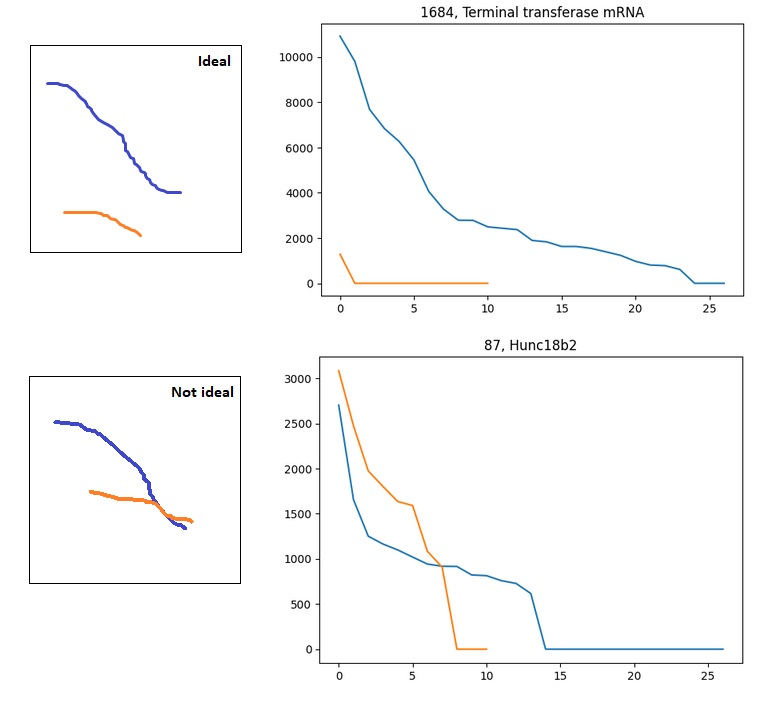

**Fig 2. An idealized (left) and a real world example (right) of both good or bad candidates (top and bottom).** 
One rectangle represents a single gene of ineterest. The lines represent the sorted expression values (from high to low) of this one gene, as found in the ALL class (blue) and the AML class (orange). 
A good candidate (top left) is where the value of the same gene in one class (blue in this case) is above of each value of the other class (orange in this case), i.e. the lowest point of the blue line is higher than the highest point of the orange. A nearly perfect real world example is shown (top right). 
A bad candidate (bottom left) is where the lines cross each other (or overlap), meaning that although the overall expression of the gene is higher in one class but due to variance there are cases where it is lower than in the other class. A real world example (bottom right). Note that although in this example the colors are swapped, but the actual color (*which class* is higher or lower) does not matter, as long as they are well separated. 


# 

The result of this step is a series of candidate genes. By tuning the parameters, the subsequent model building/training steps result weaker/stronger models. Interestingly, the different setups do not differ in the essence of the gene list of candidates, only in the cut-off point of the gene list. The different candidate lists therefore become "strict" (in extreme cases only one gene, for example GeneFoo), "less strict" (it can be for example three genes such as GeneFoo, GeneBar, GeneFooBar), and "relaxed" list with many more. A stricter list is always a subset of a previous (less strict) list. 


## Step 3: building up the models with the candidates. 

I used two models with different settings. The common path is the preparation described above:
- Changing baseline to 100.
- Normalizing to the maximum.
- Finding a gene set to feed the model based on their ratios of the median difference and subsequently t-test. 
- The gene sets applied in the two models are not the same, one is stricter than the other. 
- A gene set is a list of genes, such as \[ GeneFoo, GeneBar, GeneFooBar, GeneBarFoo, etc \]. 
- In both models a patient is represented as a point in an N-dimensional space, where the number of dimensions is the number of candidates. I.e. if there are 4 genes on the list, then a patient is a point in a 4-dimensional abstract space. 
- It means that each patient is represented by a set of numbers, in order, representing the normalized (0 to 100%) expression levels of the candidate genes in that patient. It is like Patient 22 = (100, 33, 0, 49). 


### Model 1: Distance to mean. 

Note. I am certain that this model was invented and named before me, but I could not find its "official" name. In this work I worked out this model naively and implemented it from scratch. For the purpose of this work I call it distance to mean (DTM) model. How it works:
- I created a mean version of both cancer classes, i.e. "mean-ALL" and "mean-AML".
- The means are N-dimensional points like the patients, and they represent two "imaginary patients", one having an "average ALL", the other having an "average AML". 
- The mean is calculated using all know ALL/AML patients in the train data set, by using the mean expression value of each candidate gene. 
- For example if GeneFoo had the values of 10000, 5000 and 0 in the AML patients, then the "GeneFoo-component" of GeneFoo in the mean-AML patient would be 5000. This is calculated for each dimension. 
- Then I calculate the N-dimensional distance of each actual patients from both imaginary mean-patients. Now each patient is reduced to only 2 numbers, their distance to mean-ALL, and their distance to mean-AML. 
- The two imaginary mean-patients are placed in a 2-dimensional space, when one is sitting on one corner (being the, let's sad 156-points of ALL and 0-points of AML), and the other is sitting in the opposite corner (0, 156 in this example). 
- Each patient now can be placed in this field, based on their distance to the two mean-patients (such as Patient X = (51, 123)). 
- The model calls the categories (ALL/AML) simply based on their distance, and calls undecided if the distance is the same.


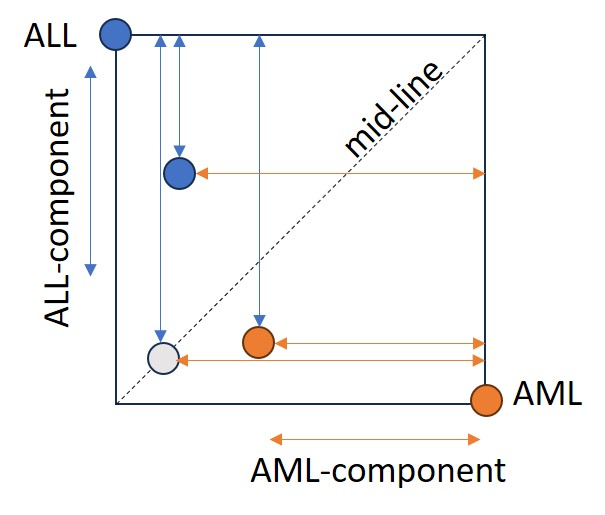

**Fig 3. An explanation of the DTM model.** The calculated "imaginary mean-patients" are on the upper left and lower right corners. Each patient is a point in this filed. Their category (color coded) is based on which component (blue = ALL or orange = AML) is the closer to the mean-point. If it is equally close (being on the mid-line), then it is undecided.

# 


### Model 2: K-nearest neighbour (KNN).

The other model used is a standard KNN model from the sklearn modul. For those who do not know, this is how it works. 
- The data is represented in an N-dimensional space. Unlike in the previous model, the N-dimensional space is fed directly to the model without flattening it out. Also no mean-patients are calculated. 
- The model calls each points based on a training. 
- During training a known dataset is presented to the model and it internally computes some distances and numbers and then applies them to the "real" or test dataset. 
- An important manually set parameter is "k", the number of how many neighbors it should consider. (It is not always the more the better.) See fig. 4. 
- To the KNN model presented in this work, I fed n-dimensional point representations prepared as for the previous model, but the gene set works best here is different from the gene set above.

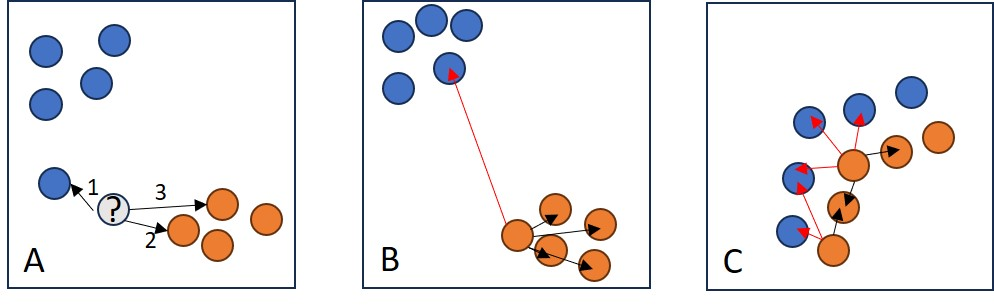

**Fig 4. An explanation of the KNN model.** 
- A: A point (gray) needs to be decided whether it belongs to the class of blue or the class of orange points. The 1st nearest neighbor is blue, but the 2nd and the 3rd are orange. The model will consider the first K neighbors based on the K parameter, and classify the point as blue or orange accordingly. 
- B: If the datapoints (represented by points in an N-dimensional abstract space) are sitting in closed clusters, then the 1st, 2nd, 3rd, 4th etc. points may be of the same class, and only when we run out of orange points, the next neighbor is blue. In this case K can be almost anything. This is an idealized optimal setup that is most often not the case. 
- C: The classes may form an abstract N-dimensional shape in the N-dimensional space where any given point is exposed to many neighbors from the other class. Here any orange point has more blue points within the first 5 neighbors, meaning that a lower K could be better. 
The abstract space itself cannot be directly observed therefore the K is set blindly, and a part of the model building is optimizing the K value by running the model with several K's. 

## Identification of gene groups. 

Genes often have common regulation that result in very similar expression patterns. In other words, genes are often not independent, and if GeneFoo is highly expressing, then GeneBar is highly expressing too (within their limits, i.e. high as compared to their levels in percentage). To assess if such common regulation happens, patient-to-patient gene expression levels can be seen as a series of values. If GeneFoo has an expression level of, for example, 70% in patient 1, and 50% in patient too etc, then this can be compared to the similar series of GeneBar as shown in fig 5. 


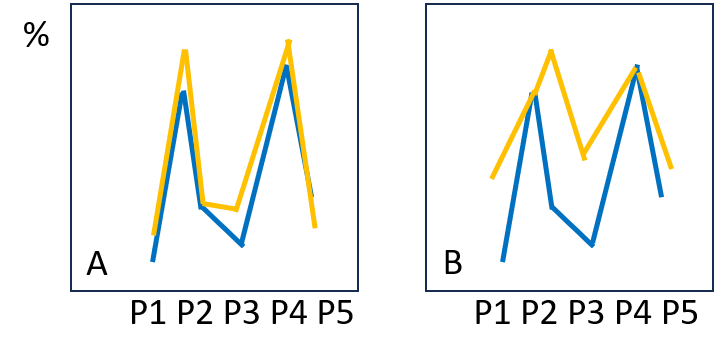

**Fig 5. Example expression patterns.**
- A: The two imaginary genes (blue and orange lines) express similarly over 5 patients (P1 to P5): the general shape, the overall ratios of changes are very similar. 
- B: These two genes have much less similarity. 

This similarity can be visualized (for illustration purposes), and can be calculated by calculating the correlation coefficient between the two genes. The following shows two real life comparisons with very high and moderate correlations. (The code for visualization is found in the last appendix: code graveyard.)

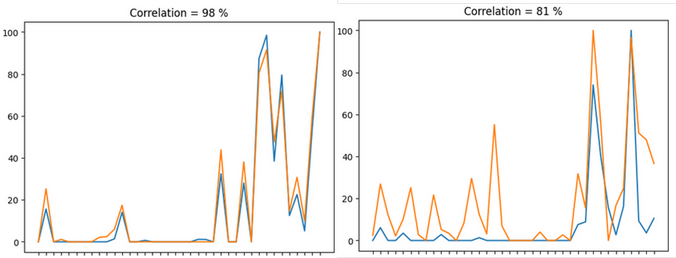

**Fig 6. Example expression patterns.**
The two Interleukin-8 expression patterns are almost identical (left). The correlation between Cystatin and the SELL gene is mediocre.



## Comparing the result to others.

One of the explicite goals of this work was to compare the results of this work to the results of others. To date, 101 notebooks were published for this problem, but only 15 of them suggest genes, the rest has models without gene names attached. 
- Most of the notebooks contain gene names as a part of a figure (i.e. not an easy-to-copy list). From those the gene names were subtracted using this online OCR tool: https://www.newocr.com/
- 3 notebooks were excluded because they were exact copies of another notebook. (Kaggle keeps track of notebook origin.)
- 1 notebook was excluded because the figure was too bad qualitiy of the OCR to read. 
- 1 notebook was excluded because of both of the above reasons (copy + bad figure quality). 

The rest of the notebooks were searched for candidate genes, and analyzed for similarities of the suggestions and the list of candidate genes. Each candidate gene was manually annotated some discrepancies were discovered between the GenBank ID and the gene names. These are also noted in the results. 

In [1]:
#imports and constants

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import math
import scipy
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

ZERO_REPLACEMENT_CONST = 100

/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv
/kaggle/input/gene-expression/data_set_ALL_AML_train.csv
/kaggle/input/gene-expression/actual.csv
/kaggle/input/metadata/metadata.csv


# 
# FUNCTION DEFINITIONS

In [2]:
def compare_median(df1, df2):
    """Comapares the medians of two gene expression series and returns the absolute value of theis log-difference"""
    df1_avg = df1.median(axis=1)
    df2_avg = df2.median(axis=1)
    out = []
    for i in range(len(df1)):
        x = df1_avg.values[i]
        y = df2_avg.values[i]
        if x < ZERO_REPLACEMENT_CONST:
            x = ZERO_REPLACEMENT_CONST
        if y < ZERO_REPLACEMENT_CONST:
            y = ZERO_REPLACEMENT_CONST
        out.append (abs(math.log(x,10) - math.log(y,10)))  
    return out

def normalize_to_hundred(arr_to_norm, maximum = None):
    """Takes all numbers in an array and sets the maximum to 100, and each other to a number between 0 and 100 relative to the ratio to the maximum.
    It can take a hand-set maximum or if none given, takes the maximum of the provided array"""
    if maximum == None:
        maximum = max(arr_to_norm)
    out = []
    for num in arr_to_norm:
        if maximum == 0:
            out.append(0)
        else:
            out.append((num/maximum)*100)
    return out


def get_t_value(df1, df2, Loc):
    """Returns the p value of a T-test from the same gene of different df's"""
    arr1 = df1.loc[Loc]
    arr2 = df2.loc[Loc]
    t, p = scipy.stats.ttest_ind(arr1, arr2)
    return p

def get_distance(arr1, arr2):
    """Returns the eucledian distance of 2 n-dimensional points. The n-dimensional points are represented in as lists of numbers (coordinates)
    As the eucledian distance cannot handle 0s (due to zero division within the method), nullvectors (when each coordinates are 0) are simply output as 0 distance"""
    arr_concat = arr1+arr2
    maximum = max(arr_concat)
    if max (arr_concat) != 0:
        return scipy.spatial.distance.euclidean(normalize_to_hundred(arr1, maximum), normalize_to_hundred(arr2, maximum))
    else:
        return 0
    


def make_Y_X_df(L_gene_list, M_gene_list, L_cases, M_cases):
    """This creates the X/Y datasets to be fed in the KNN model"""
    X = L_gene_list + M_gene_list
    Y = [0]*len(L_cases) + [1]*len(M_cases)
    dfX = pd.DataFrame(X)
    return dfX, Y
    

def make_genelists(caseL, caseM, dfL, dfM, candidates):
    """It returns a normalized gene activity list for each patient for each gene from the candidate list. 
    Output format: Assuming the candidate list contains 3 genes and ALL has 3 patients while AML has 2 patients, then:
    [[[100, 10, 20],[80, 20, 30][50, 60, 15]],[[0, 80, 100][10, 75, 86]]], brroken down:
    [[ALL_patients],[AML_patients]] >>> 
    [[[P1, P2, P3]],[P4, P5]] >>>
    [[[Gene1 Gene2 Gene3],[Gene1 Gene2 Gene3],[Gene1 Gene2 Gene3]],[[Gene1 Gene2 Gene3],[Gene1 Gene2 Gene3]]]"""
    outL = []
    outM = []
    for case in caseL:
        caseL_activities = []
        for candidate in candidates:
            caseL_activities.append(dfL[case].loc[candidate])
        outL.append(caseL_activities)
    for case in caseM:
        caseM_activities = []
        for candidate in candidates:
            caseM_activities.append(dfM[case].loc[candidate])
        outM.append(caseM_activities)
    return outL, outM


def fetch_name(df, n, what = 0):
    """This returns the name of the gene based on the index. """
    if what == 0:
        return df.iloc[n]["Gene Accession Number"]
    elif what == 1:
        return df.iloc[n]["Gene Description"]
    else:
        return (df.iloc[n]["Gene Description"], df.iloc[n]["Gene Accession Number"])
    


def get_coeff(df, n1, n2):
    """It is a helper function used in other function to return the correlation coefficient of two gene sets."""
    a = list(df.iloc[n1]+0.001)
    b = list(df.iloc[n2]+0.001)
    return int((np.corrcoef(a, b)[0][1])*100)

def get_coeff_matrix(df_norm, candidates, make_fig = True, size = 10):
    "This is a single shot function that could have been a cell. It builds up a correlation coefficient heat map between each pair in a gene list."
    length = len(candidates)
    arr = np.zeros((length,length))
    for i in range(length):
        for j in range(length):
            arr[i][j]= get_coeff(df_norm, candidates[i], candidates[j])
    if make_fig:
        colors = ['black', 'darkgrey', 'yellow', 'orange', 'red', 'darkred']
        cmap = ListedColormap(colors)
        bounds = [75, 80, 85, 90, 95, 99, 100]
        norm = BoundaryNorm(bounds, ncolors=len(colors))
        mask = np.zeros_like(arr)
        mask[np.triu_indices_from(mask)] = True
        fig = plt.figure(figsize=(size, size))
        ax = plt.subplot()
        sns.heatmap(arr,
                    mask=mask,
                    ax=ax,
                    norm = norm, 
                    cbar=True,
                    cmap=cmap,
                    xticklabels=True,
                    yticklabels=True)
        plt.show()
    else:
        print(arr)
        
            

def get_coeff_groups(df_norm, candidates, coeff = 85):
    """Returns a group of genes that are grouped together based on their coefficient similariites to each other"""
    out = []
    for i in range(len(candidates)):
        out.append([])
        for j in range(i, len(candidates)):
            if get_coeff(df_norm, candidates[i], candidates[j]) >= coeff:
                out[i].append(candidates[j])
        if len(out[i]) == 1:
            for k in range(len(out)-1):
                if out[i][0] in out[k]:
                    out[i][0] = "-"
    for outlist in out:
        if outlist == ["-"]:
            out.remove(outlist)
    return out
    



def calculate_middle_point(df_norm, candidates):
    """assumes that the df is the normalized version
    returnes the 'imaginary patient' for the model DTM """
    out = []
    df = df_norm.copy()
    df["mean"] = df.mean(axis=1)
    for i in range(len(df)):
        if i in candidates:
            out.append(df["mean"].loc[i])
    return out

def get_candidates (threshold, dfL, dfM,p_val = 0.001):
    """takes the split X and Y (as dfL+dfM for X )
    takes variables for p and similarity thresholds
    returns a set of candidate gene identifiers (list of int)"""
    comparisons = compare_median(dfL, dfM) #this is a 7000+ long list of the two median
    candidates = []
    for i in range(len(comparisons)):
        if comparisons[i] >= threshold:
            if get_t_value(dfL, dfM, i) <= p_val:
                candidates.append(i)
    return candidates

    

def get_N_dimensional_vectors(dfLnorm, dfMnorm, caseL, caseM, candidates):
    """takes the normalized dfs and creates vectors for each 
    returns the coordinates of both L-type and M-type cases
    the vectors are in N-dimensional space where N is the number of candidates. """
    ALL_coordinates = []
    AML_coordinates = []
    for case in caseL:
        caseL_activities = []
        for candidate in candidates:
            caseL_activities.append(dfLnorm[case].loc[candidate])
        ALL_coordinates.append(caseL_activities)
    for case in caseM:
        caseM_activities = []
        for candidate in candidates:
            caseM_activities.append(dfMnorm[case].loc[candidate])
        AML_coordinates.append(caseM_activities)
    return ALL_coordinates, AML_coordinates


def calculate_all_distances(L_vectors, M_vectors, L_avg_point, M_avg_point):
    """Takes N-dimensional vectors and the calculated average-points and returns the points as coordinates 
    the coordinate format is (L-distance, M-distance)
    In separate tuples, the """
    corner_distance = get_distance(L_avg_point, M_avg_point)
    corner_distances = [[corner_distance,0], [0,corner_distance]]
    L_distances = [[],[]] # L point to L vectors, L-point to M-vectors
    M_distances = [[],[]] # M point to L vectors, M-point to M-vectors
    for vector in L_vectors:
        L_distances[0].append(get_distance(vector, L_avg_point))
        M_distances[0].append(get_distance(vector, M_avg_point))
    for vector in M_vectors:
        L_distances[1].append(get_distance(vector, L_avg_point))
        M_distances[1].append(get_distance(vector, M_avg_point))
    return corner_distances, L_distances, M_distances
                        

def call_category(L_distances, M_distances):
    """assumes arrays of equal length
    calls based on closes distances"""
    out = []
    for i in range(len(L_distances)):
        if L_distances[i] > M_distances[i]:
            out.append("M")
        elif L_distances[i] < M_distances[i]:
            out.append("L")
        else:
            out.append("U")
    return out


    
def illustrate_distances_subs(corners,L_distances, M_distances, ax, title):
    """assumes tuples with the corrsponding distance values"""
    if ax is None:
        ax = plt.scatter()
    ax.set_title(title)
    a= ax.scatter(L_distances[0], L_distances[1]) 
    b= ax.scatter(M_distances[0], M_distances[1])
    c= ax.scatter(corners[0], corners[1])
    d = ax.plot(range(int(corners[0][0])))
    return a, b, c


def illustrate_conf_matrix(cm, ax, title):
    """Creates heat maps for the confision matrices"""
    if ax is None:
        ax = plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['ALL', 'AML'], yticklabels=['ALL', 'AML'], ax = ax)
    ax.set_title(title)

    

def fetch_name_by_acc (acc, df):
    """A helper function I needed to fetch name by the acc number"""
    number = df.index[df['Gene Accession Number'] == acc].tolist()[0] 
    out_gene, out_acc = fetch_name(df, number , what = 2)
    return number, out_gene, out_acc

def idx_by_partial_name(acc, df):
    """Another helper function to fetch index using the partial acc number
    Partial as in the 'A00000_at' format is trincated to 'A00000' in the Golub paper
    As it turns out a truncated ID can lead to more indices, because it can be 
    A00000_at, and e.g. A00000_s_at which is essentially the two copies of the same gene"""
    out = []
    for i in range(len(df)):
        if df['Gene Accession Number'].loc[i].split("_")[0] == acc:
            out.append(i)
    return out
    

    

# 
# DATA PREPARATION 

According to how it is described in methods.

In [3]:
df_meta = pd.read_csv("/kaggle/input/metadata/metadata.csv")

In [4]:
#getting the patient_number:cancer_type keys.

df_keys= pd.read_csv('/kaggle/input/gene-expression/actual.csv')

keys = {}

for i in range(len(df_keys)):
    keys[str(df_keys.loc[i]["patient"])] = df_keys.loc[i]["cancer"]

In [5]:
#preparing and separating the test dataframes

df_indep = pd.read_csv('/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv')

df_indep = df_indep.replace("P", 1)
df_indep = df_indep.replace("A", 0)
df_indep = df_indep.replace("M", 0)

samples_indep = [] # each column name will come here
calls_indep = [] #the call, call.1 etc volumn names will come here
ALL_indep = [] # L-type column names will come here
AML_indep = [] # N-type columns will come here

df_ALL_test = pd.DataFrame() #not normalized df wit only L tpye
df_AML_test = pd.DataFrame() # same but M
df_ALL_test_norm = pd.DataFrame() # normalized L
df_AML_test_norm = pd.DataFrame() # same but M
df_test = pd.DataFrame() #df with all values
df_test_norm = None #same but normalized It is None for now, storing the name here

#---------------------------- PROCESSING THE DATA -----------------------------------------------------------------

header_indep = list(df_indep.columns.values)  #temp storage of each column names

for i  in range(len(header_indep)):
    #skip the first two column names then store them alternating such as "39" and "call" and "40" and "call.1" 
    if i < 2:
        pass
    elif i%2 == 0:
        samples_indep.append(header_indep[i])
    else:
        calls_indep.append(header_indep[i])
        
for sample in samples_indep:
    #Sorting the cases into L and M type. 
    if keys[sample] == "ALL":
        ALL_indep.append(sample)
    else:
        AML_indep.append(sample)

for i in range (len(calls_indep)):
    #multiplication of the former A/M/P now 0/0/1 values with their own neighbor
    df_test[samples_indep[i]] = df_indep[samples_indep[i]] * df_indep[calls_indep[i]]
    

df_temp_ind = df_test.copy() # A temporary df is needed here because header addition is not working as it supposed.    
    
df_temp_ind = df_temp_ind.apply(normalize_to_hundred, axis = 1)
df_test_norm = pd.DataFrame(columns = samples_indep)

for i in range (len(df_temp_ind)):
    #loading back from the temp to the actual one I want to use
    df_test_norm.loc[i]= df_temp_ind.loc[i]


for i in range(len(ALL_indep)):
    df_ALL_test[ALL_indep[i]] = df_test[ALL_indep[i]]

for i in range(len(AML_indep)):
    df_AML_test[AML_indep[i]] = df_test[AML_indep[i]]
    
for i in range(len(ALL_indep)):
    df_ALL_test_norm[ALL_indep[i]] = df_test_norm[ALL_indep[i]]

for i in range(len(AML_indep)):
    df_AML_test_norm[AML_indep[i]] = df_test_norm[AML_indep[i]]

df_temp_ind = None #I dont need it anymore

df_test.head()

/tmp/ipykernel_18/38743854.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_indep = df_indep.replace("M", 0)


,39,40,42,47,48,49,41,43,44,45,...,54,57,58,60,61,65,66,63,64,62
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,319,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#doing the same prcedure for training data

df_train = pd.read_csv('/kaggle/input/gene-expression/data_set_ALL_AML_train.csv')

df_train = df_train.replace("P", 1)
df_train = df_train.replace("A", 0)
df_train = df_train.replace("M", 0)

samples_train = []
calls_train = []
ALL_train = []
AML_train = []

df_ALL_tr = pd.DataFrame()
df_AML_tr = pd.DataFrame()
df_ALL_tr_norm = pd.DataFrame()
df_AML_tr_norm = pd.DataFrame()
df_tr = pd.DataFrame()
df_tr_norm = None

#---------------------------- PROCESSING THE DATA -----------------------------------------------------------------

header_train = list(df_train.columns.values)

for i  in range(len(header_train)):
    #skip the first two column names then store them alternating such as "39" and "call" and "40" and "call.1" 
    if i < 2:
        pass
    elif i%2 == 0:
        samples_train.append(header_train[i])
    else:
        calls_train.append(header_train[i])
        
for sample in samples_train:
    #Sorting the cases into L and M type. 
    if keys[sample] == "ALL":
        ALL_train.append(sample)
    else:
        AML_train.append(sample)


for i in range (len(calls_train)):
    #multiplication of the former A/M/P now 0/0/1 values with their own neighbor
    df_tr[samples_train[i]] = df_train[samples_train[i]] * df_train[calls_train[i]]

df_temp_tr = df_tr.copy()   
 
df_temp_tr = df_temp_tr.apply(normalize_to_hundred, axis = 1)
df_tr_norm = pd.DataFrame(columns = samples_train)

for i in range (len(df_temp_tr)):
    #loading back from the temp to the actual one I want to use
    df_tr_norm.loc[i]= df_temp_tr.loc[i]


for i in range(len(ALL_train)):
    df_ALL_tr[ALL_train[i]] = df_tr[ALL_train[i]]

for i in range(len(AML_train)):
    df_AML_tr[AML_train[i]] = df_tr[AML_train[i]]

for i in range(len(ALL_train)):
    df_ALL_tr_norm[ALL_train[i]] = df_tr_norm[ALL_train[i]]

for i in range(len(AML_train)):
    df_AML_tr_norm[AML_train[i]] = df_tr_norm[AML_train[i]]
    
df_temp_tr = None

df_AML_tr_norm.head()

/tmp/ipykernel_18/3925564400.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train = df_train.replace("M", 0)


,34,35,36,37,38,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,58.673469,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [7]:
df_train.head(100)

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,0,-139,0,-76,0,-135,0,...,15,0,-318,0,-32,0,-124,0,-135,0
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,0,-73,0,-49,0,-114,0,...,-114,0,-192,0,-49,0,-79,0,-186,0
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,0,-1,0,-307,0,265,0,...,2,0,-95,0,49,0,-37,0,-70,0
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,0,283,0,309,0,12,0,...,193,0,312,0,230,1,330,0,337,0
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,0,-264,0,-376,0,-419,0,...,-51,0,-139,0,-367,0,-188,0,-407,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,WUGSC:H_133K23.1c gene extracted from Human BA...,AC000061_cds3_at,-206,0,-87,0,-183,0,-254,0,...,-86,0,-147,0,-44,0,-133,0,-192,0
96,GB DEF = PAC clone 2G3A from 13q12-13q13; comp...,AC000062_at,20,0,13,0,-33,0,-9,0,...,11,0,15,0,-19,0,-16,0,-44,0
97,WUGSC:H_RG083M05.2 gene extracted from Human B...,AC000064_cds1_at,271,0,595,1,457,0,414,0,...,321,1,536,1,565,0,519,1,596,0
98,WUGSC:H_RG083M05.1 gene extracted from Human B...,AC000064_cds2_at,78,0,142,1,205,1,142,0,...,129,0,103,1,154,1,172,1,266,1


# 
# RESULTS


**The first important step is to compare each gene expressions in ALL and in AML The highest difference is about 100-fold (log10 = 2).**

In [8]:
gene_med_comparisons = compare_median(df_ALL_tr, df_AML_tr)


#it containss 7000 compariosn 
print("Total of comparisons: ", len(gene_med_comparisons), "- the same as the length of the dataframe. \n")
print ("The largest fold-difference (log):", max(gene_med_comparisons), "\n")
print("A sample of the comparison values:\n", gene_med_comparisons[:100])

Total of comparisons:  7129 - the same as the length of the dataframe. 

The largest fold-difference (log): 2.0018634626925236 

A sample of the comparison values:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02865281085473903, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03751636126788904, 0.1952811219724162, 0.4925416135871563, 0.25165220310993996, 0.1350326067210199, 0.03869399523540995, 0.03411061982398511, 0.025170745881506917, 0.005148847537028267, 0.0391887542504783, 0.26073540080480795, 0.0, 0.42100531274073116, 0.21494101651927489, 0.0, 0.0, 0.0356178592097951, 0.0, 0.5352941200427699, 0.10558830231347116, 0.0, 0.7084209001347124, 0.0, 0.0, 0.07999377104029692, 0.0, 0.0, 0.3654879848908994, 0.0, 0.039114091527673533, 0.0, 0.0286451814495301, 0.0, 0.0, 0.14612803567823773, 0.0, 0.0, 0.0, 0.0, 0.0, 0.059545775046308425, 0.03751310567486277, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41

# 

**Next, the effect of cutoff threshold is assessed. I.e. threshold of required log-fold difference, meaning that if the threshold is 1, then the required mean-difference is 10-fold between the median expression levels of the given gene in AML versus ALL. (See more in Methods: Step 2: finding the model selection method.)**

When threshold = 0.1 the number of candidate genes = 1403
When threshold = 0.2 the number of candidate genes = 933
When threshold = 0.3 the number of candidate genes = 677
When threshold = 0.4 the number of candidate genes = 522
When threshold = 0.5 the number of candidate genes = 400
When threshold = 0.6 the number of candidate genes = 292
When threshold = 0.7 the number of candidate genes = 208
When threshold = 0.8 the number of candidate genes = 156
When threshold = 0.9 the number of candidate genes = 109
When threshold = 1.0 the number of candidate genes = 74
When threshold = 1.1 the number of candidate genes = 49
When threshold = 1.2 the number of candidate genes = 37
When threshold = 1.3 the number of candidate genes = 26
When threshold = 1.4 the number of candidate genes = 14
When threshold = 1.5 the number of candidate genes = 12
When threshold = 1.6 the number of candidate genes = 8
When threshold = 1.7 the number of candidate genes = 5
When threshold = 1.8 the number of candi

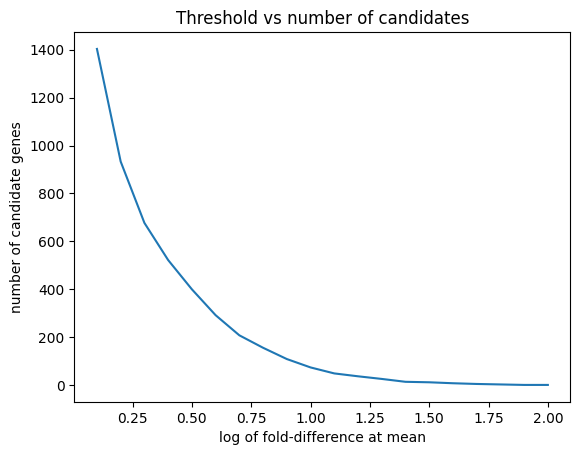

In [9]:
x = []
y = []
for i in range (1, 21):
    x.append(i/10)
    counter = 0
    for comp in gene_med_comparisons:
        if i <= comp*10:
            counter +=1
    y.append(counter)
    print ("When threshold =", i/10, "the number of candidate genes =", counter)
    
plt.plot(x, y)
plt.title("Threshold vs number of candidates")
plt.xlabel("log of fold-difference at mean")
plt.ylabel("number of candidate genes")
plt.show()


**Fig. 7 (description in text)**
# 
**As seen on the curve in fig 7, there is no breakpoint, or minimum, or any naturally occurring number that could be a starting point for the threshold. However it is clear that around 1.1, the number of genes reach the number suggested by Golub et al, that can be a starting point. For the rest of the model building, threshold values between 1 and 2 are considered.**

# 

**The code below, resulting inf Fig 8, shows the t-test p-values when two arbitrarily chosen thresholds are tested (1.0 and 1.4). As the resulting graph shows, even with the more allowing threshold, there are plenty of candidate genes way below a t-test p value of 0.1. After many round of experimentation (not shown), a p-value of 0.001 was chosen for further use.**

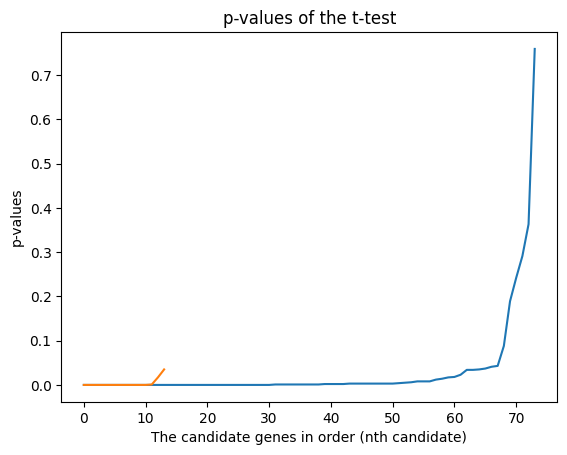

In [10]:
candidates_at_10 = []
candidates_at_14 = []

for i in range(len(gene_med_comparisons)):
    if gene_med_comparisons[i] >= 1.4:
        candidates_at_10.append(i)
        candidates_at_14.append(i)
    elif gene_med_comparisons[i] >= 1.0:
        candidates_at_10.append(i)
#return candidates


p_values_at_10 = []
p_values_at_14 = []

for candidate in candidates_at_10:
    p_values_at_10.append(round(get_t_value(df_ALL_tr, df_AML_tr, candidate),3))

for candidate in candidates_at_14:
    p_values_at_14.append(round(get_t_value(df_ALL_tr, df_AML_tr, candidate),3))


plt.title("p-values of the t-test")
plt.ylabel("p-values")
plt.xlabel("The candidate genes in order (nth candidate)")
plt.plot(sorted(p_values_at_10))
plt.plot(sorted(p_values_at_14))
plt.show()

**Fig 8 (see text)**


## Optimizing the Distance to Mean model paramaters


**Using a pre-set p-value of 0.001 and a variable threshold between 1 and 2, the train set shows the best separation at lower threshold values.**

['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
['M', 'L', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
['M', 'L', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
['M', 'L', 'M', 'M', 'M', 'M', 'M', 'M',

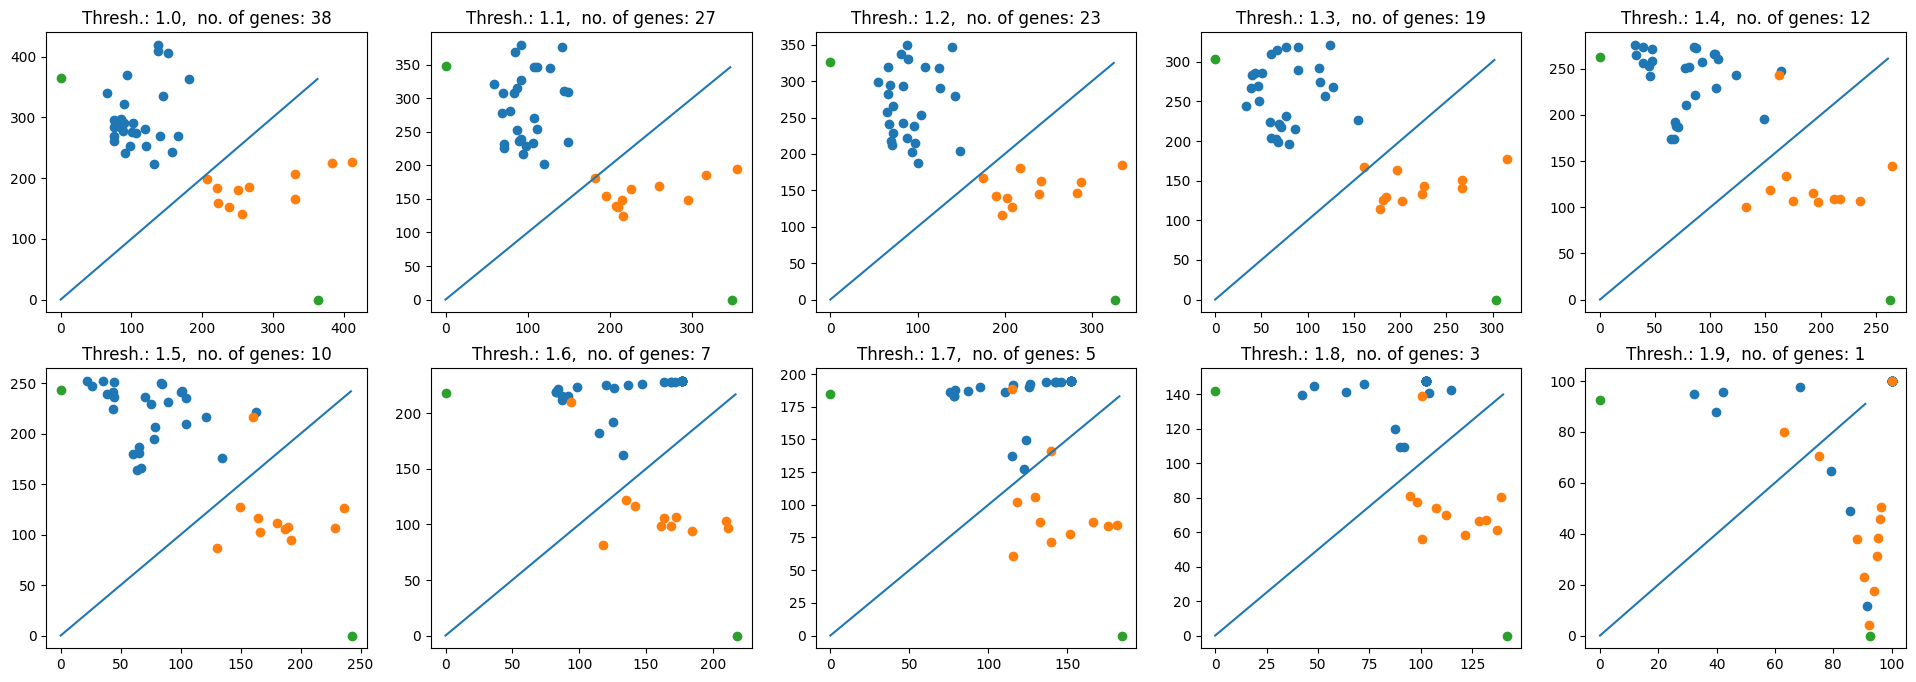

In [11]:
x=2
y=5
fig, ax = plt.subplots(nrows=x, ncols=y, figsize=(24, 8))
counter = 0
for i in range (x):
    for j in range(y):
        n = 1+(counter/10)
        cand = get_candidates(n, df_AML_tr, df_ALL_tr)
        L, M = get_N_dimensional_vectors(df_ALL_tr_norm, df_AML_tr_norm, ALL_train, AML_train, cand)
        cd, ld, md = calculate_all_distances(L, M, calculate_middle_point(df_ALL_tr_norm, cand),  calculate_middle_point(df_AML_tr_norm, cand))
        print(call_category(ld[1], md[1]), call_category(ld[0], md[0]))
        illustrate_distances_subs((cd[0], cd[1]),(ld[0], md[0]),(ld[1],md[1]), ax[i,j], f"Thresh.: {n},  no. of genes: {len(cand)}")
        counter +=1

**Fig 9 (see text)**

### The test set

**The test dataset performs similarly good at the lowest threshold. At threshold = 1 only 1 AML patient (orange) of 14 is mis-categorized, and every ALL patients are called according to their category.**

['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'L', 'M', 'M', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
['M', 'M', 'M', 'M', 'L', 'M', 'M', 'L', 'M', 'M', 'L', 'M', 'M', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'L', 'M', 'M', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'L', 'M', 'L', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
['M', 'M', 'M', 'M', 'M', 'M', 'M', 'L', 'M', 'M', 'L', 'M', 'L', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
['M', 'M', 'M', 'M', 'M', 'M', 'M', 'L', 'L', 'M', 'L', 'M', 'L', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L'

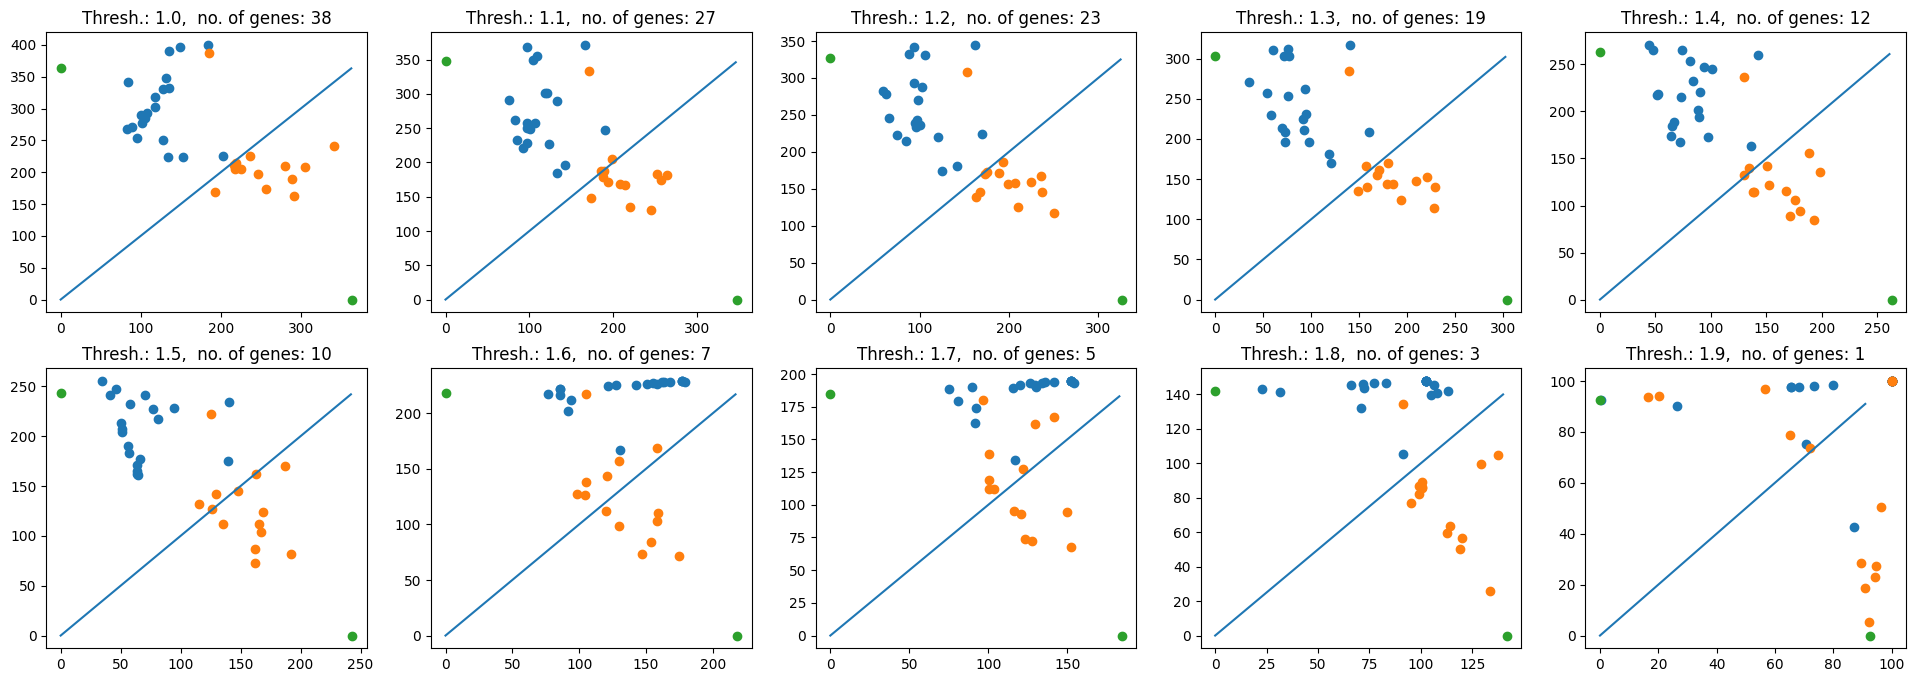

In [12]:
x=2
y=5
fig, ax = plt.subplots(nrows=x, ncols=y, figsize=(24, 8))
counter = 0
for i in range (x):
    for j in range(y):
        n = 1+(counter/10)
        cand = get_candidates(n, df_ALL_tr, df_AML_tr)
        L, M = get_N_dimensional_vectors(df_ALL_test_norm, df_AML_test_norm, ALL_indep, AML_indep, cand)
        cd, ld, md = calculate_all_distances(L, M, calculate_middle_point(df_ALL_tr_norm, cand),  calculate_middle_point(df_AML_tr_norm, cand))
        print(call_category(ld[1], md[1]), call_category(ld[0], md[0]))
        illustrate_distances_subs((cd[0], cd[1]),(ld[0], md[0]),(ld[1],md[1]), ax[i,j], f"Thresh.: {n},  no. of genes: {len(cand)}")
        counter +=1

**Fig 10 (see text)**

## Identification of gene groups

The candidate gene list may have several genes that are either the same or at least have very similar regulation. If so, it means that a pattern is represented twice or more in the model, giving a an unintended two- or more-fold weight to the model. 
Fig 11 shows a pairwise comparison (correlation coefficient) of each gene in the candidate gene list. 

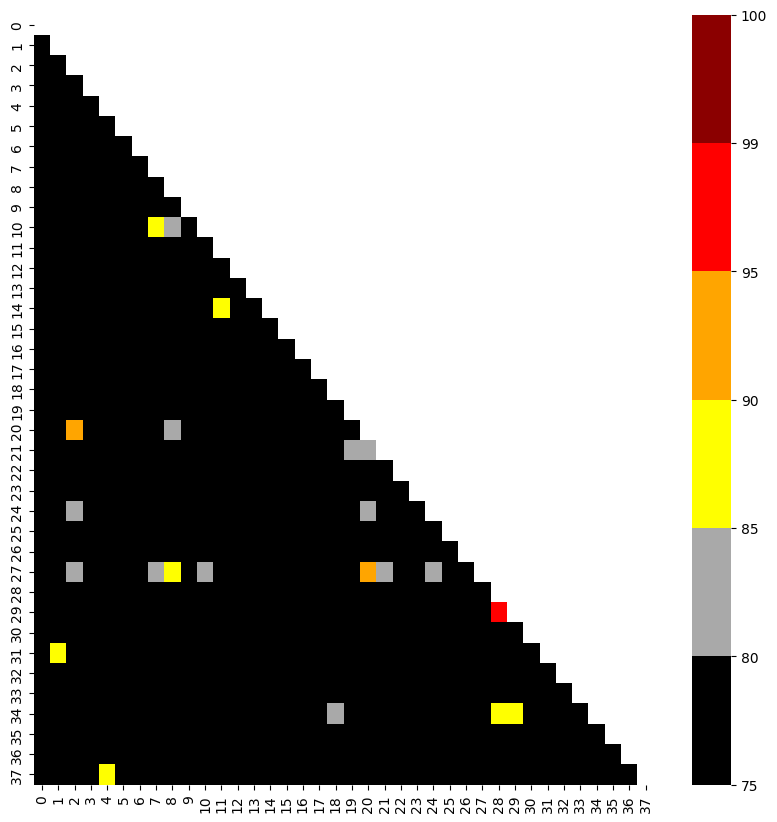

0 = 311 ('NADPH-flavin reductase', 'D26308_at')
1 = 378 ('AARS Alanyl-tRNA synthetase', 'D32050_at')
2 = 759 ('CYSTATIN A', 'D88422_at')
3 = 921 ('Nuclear Factor Nf-Il6', 'HG3494-HT3688_at')
4 = 1119 ('SNRPN Small nuclear ribonucleoprotein polypeptide N', 'J04615_at')
5 = 1132 ('CATHEPSIN G PRECURSOR', 'J04990_at')
6 = 1778 ('MPO Myeloperoxidase', 'M19507_at')
7 = 1828 ('PPGB Protective protein for beta-galactosidase (galactosialidosis)', 'M22960_at')
8 = 1881 ('CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage)', 'M27891_at')
9 = 2042 ('LGALS3 Lectin; galactoside-binding; soluble; 3 (galectin 3) (NOTE: redefinition of symbol)', 'M57710_at')
10 = 2120 ('CTSD Cathepsin D (lysosomal aspartyl protease)', 'M63138_at')
11 = 2287 ('DF D component of complement (adipsin)', 'M84526_at')
12 = 2353 ('CCND3 Cyclin D3', 'M92287_at')
13 = 2393 ('PLCB2 Phospholipase C; beta 2', 'M95678_at')
14 = 2401 ('Azurocidin gene', 'M96326_rna1_at')
15 = 2641 ('MB-1 gene', 'U05259_rna1_at')
16 = 3251 

In [13]:
candidates_dtm = get_candidates(1, df_AML_tr, df_ALL_tr)

get_coeff_matrix(df_AML_tr_norm, candidates_dtm)

for i in range(len(candidates_dtm)):
    print(i, "=", candidates_dtm[i], fetch_name(df_train,candidates_dtm[i], 2))

**Fig 11 (see text)**

## Finding candidate groups

**Using default settings of get_coeff_groups (85% correlation), the following groups were created.**

In [14]:
print(get_coeff_groups(df_AML_tr_norm, candidates_dtm))

[[311], [378, 6264], [759, 4372], [921], [1119, 6701], [1132], [1778], [1828, 2120], [1881, 6184], [2042], [2287, 2401], [2353], [2393], [2641], [3251], [3253], [3709], [4365], [4372, 6184], [4846], [5008], [5038], [5793], [5889], [5975], [6199, 6200, 6307], [6200, 6307], [6214], [6282], [6284], [6313], [6372]]


# Gene groups of the resuling candidate genes. 

Due to the author's personal drive and interest in gene regulation, an attempt was made to find biological connections that might be the underlining cause of the genes grouping together in seemingly high co-regulation.
**Although in many cases there appears to be a plausible cause, this part of the work is highly speculational.** 

# 

***

## Group 1

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|311   |NADPH-flavin reductase (D26308)||

*** 

## Group 2

Connection: JunB regulates AARS in endothelial cells in hypoxia. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2064707/

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|378|AARS Alanyl-tRNA synt. (D32050)| |
|6264|JUNB JunB proto-oncogene (U20734)||

***


## Group 3

Connection: Known interaction listed on protein atlas: https://www.proteinatlas.org/ENSG00000121552-CSTA/interaction

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|759|CYSTATIN A (D88422)||
|4372|GRN Granulin (X62320)|Note GRN in group 12|

***


## Group 4

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|921|Nuclear Factor Nf-Il6 (D63161)|N/A|Original ID was HG3494-HT3688||

***

## Group 5

Connection: Known role in mRNA procession. https://www.intechopen.com/chapters/18464 

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|1119|snRNP polypept. N. (J04615)|Typo in name (“SNRPN”)||
|6701|LPAP gene (X97267)|Better known as PTPRCAP or LSM-1||

***


## Group 6

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|1132|CATHEPSIN G PRECURSOR (J04990)||

***


## Group 7

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|1778|MPO Myeloperoxidase (M19507)||

***


## Group 8

Connection: Nothing in particular found (other than both are cathepsins).

|#in DF|Name (GB ID)| Remark|
|------|------------|------|
|1828|PPGB Protective protein (M22960)|Known as cathepsin A|
|2120|CTSD Cathepsin D (AH002629)|The original ID (M63138) is now replaced.) |

***


## Group 9

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|1881|CST3 Cystatin C (M27891)||
|6184|\[LFA-1 + CD18 cluster\] |Mis-annotation?| 

            There is a mismatch between the gene name and the ID Selectin L (LFA-1) is M25280,while X64072 is CD-18. According to a source available at Broad Institute, these might be a single cluster. https://pubs.broadinstitute.org/mpr/projects/Metastasis/Mets_Supplement_Information_041110_KR.xls

***        

## Group 10

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|2042|IgE (M57710)||The gene name in the DF is confusing but it is IgE in fact. Cross checked with Affymetrix chip.|

***


## Group 11

Connections: Common regulation https://www.sciencedirect.com/science/article/pii/S000649712036688X?via%3Dihub  + Common gene cluster by cell type: https://www.proteinatlas.org/ENSG00000172232-AZU1/cell+line 

|#in DF|Name (GB ID)|Remark|Suggested elsewhere|
|------|------------|------|-------------------|
|2287|Adipsin (M84526)|aka: CFD| Golub et al |
|2401|Azurocidin (M96326)||Golub et al.|

***

## Group 12


|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|4372|GRN Granulin (X62320)|Notice GRN in group 3|
|6184|\[LFA-1 + CD18 cluster\] |Mis-annotation?|

            There is a mismatch between the gene name and the ID Selectin L (LFA-1) is M25280,while X64072 is CD-18. According to a source available at Broad Institute, these might be a single cluster. https://pubs.broadinstitute.org/mpr/projects/Metastasis/Mets_Supplement_Information_041110_KR.xls

***
    

## Group 13

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|2353|Cyclin D3 (M92287)|

***


## Group 14

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|2393|PLCB2 Phospholipase C (M95678)||

***


## Group 15

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|2641|MB-1 (U05259)||

***


## Group 16

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|3251|MGST1 (U46499)||


***

## Group 17

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|3253|Tetratricopeptide repeat protein /TPR1, TTC1/ (U46570)||



***

## Group 18

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|3709|LITAF (U77396)||Was unannotated in the database.

***

## Group 19

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|4365|ARHG Ras homolog gene family; member G /rho G/ (X61587)||



***

## Group 20

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|4846|Zyxin (X95735)||

***

## Group 21

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|5008|SIRP-beta1 (Y10376)||


***

## Group 22

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|5038|LEPROT(Y12670)|Named as leptin receptor in Golub et al.|

***

## Group 23

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|5793|LMNA Lamin A (M13452)||


***

## Group 24

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|5889|Dematin (unknown)|The original Affymetrix ID is HG4535-HT4940_s_at|


***

## Group 25

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|5975|LYZ Lysozyme (M21119)|Another copy of Lyz was suggested  by Golub et al, but it did not make the cut into this gene set.|

***

## Group 26

Connection: IL-8 and GRO2: Known co-regulation in colon cancer. https://pubmed.ncbi.nlm.nih.gov/20162422/ The two instances of IL-8 that made into the candidate list groups together. 


|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|6199|Interleukin 8 (M28130)| |
|6200|Interleukin 8 (Y00787)| |
|6307|GRO2 oncogene (M57731)|The gene ID is suggested by Golub et al but named as lectin.|

***

## Group 27

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|6214|Human myeloperoxidase gene; ex 1-4 (M19508)||

***

## Group 28

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|6282|TCF3 / HE47 / E2A IGEBF E12-E47 (M65214)||


***

## Group 29

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|6284|Proto-oncogene BCL3 (AH006679)|The original ID (U05681) is now replaced.|


***

## Group 30

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|6313|Transforming growth factor-beta (M38449)||


***

## Group 31

|#in DF|Name (GB ID)|Remark|
|------|------------|------|
|6372|ITGAX aka CD11C (M81695)||


## Running the model with one gene per group

**To remove the weight factors, one gene was manually selected from each group. The resulting subset of candidate genes was used to run the model again. The result are shown in Fig 12.**

['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
['M', 'M', 'M', 'M', 'L', 'L', 'M', 'L', 'M', 'L', 'L', 'M', 'L', 'M'] ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'M', 'L', 'L', 'L']


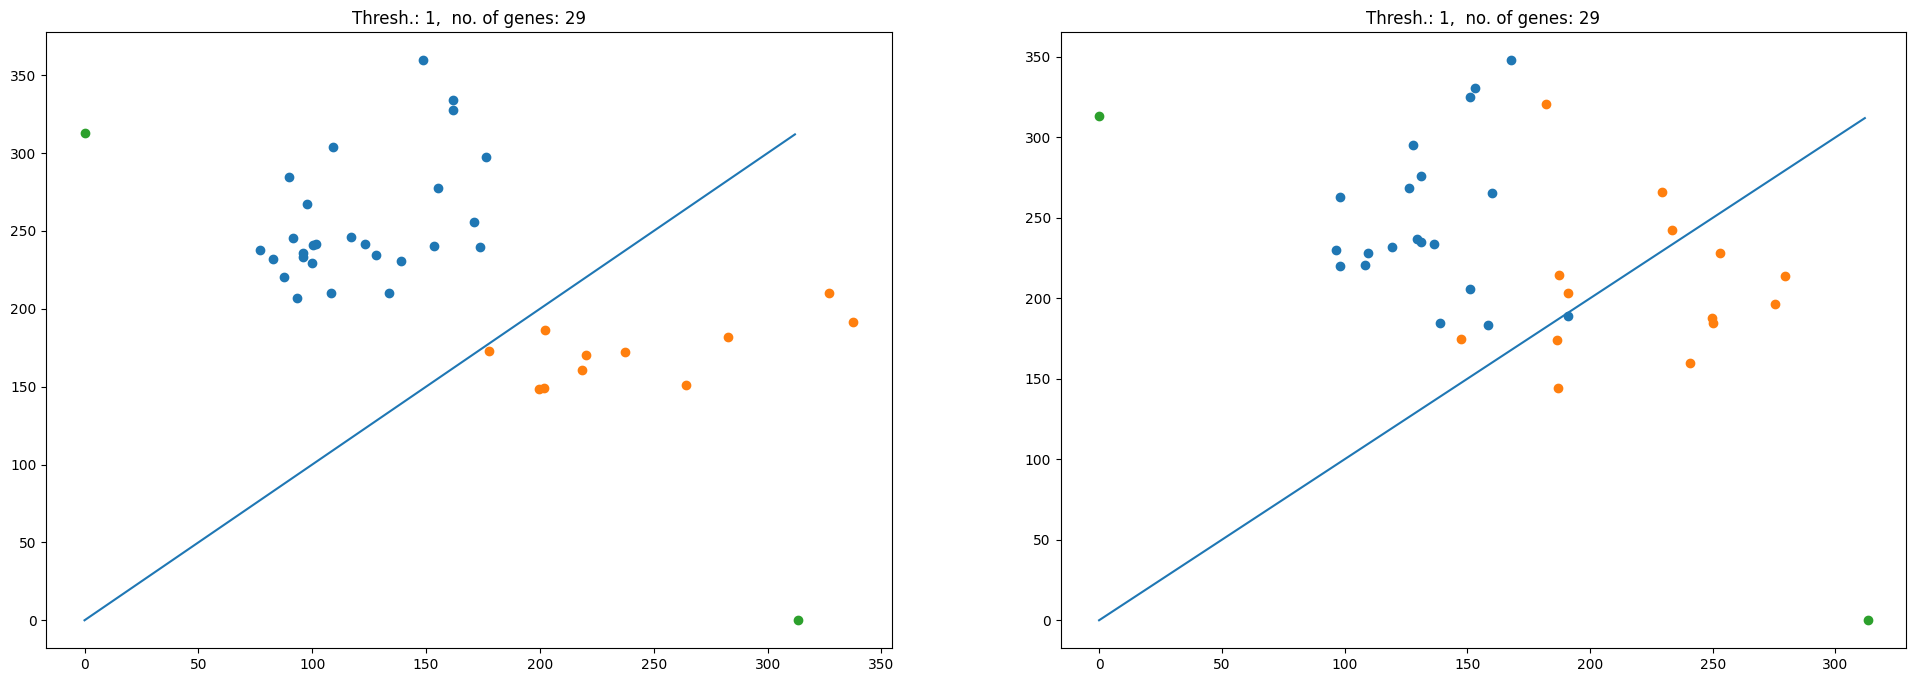

In [15]:
narrow_dtm = [311, 378, 759, 921, 1119, 1132, 1828, 1881, 2042, 2401, 2353, 2393, 2641, 3251, 3253, 3709, 4365, 4846, 5008, 5038, 5793, 5889, 5975, 6199, 6214, 6282, 6284, 6313, 6379]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

L1, M1 = get_N_dimensional_vectors(df_ALL_tr_norm, df_AML_tr_norm, ALL_train, AML_train, narrow_dtm)
cd1, ld1, md1 = calculate_all_distances(L1, M1, calculate_middle_point(df_ALL_tr_norm, narrow_dtm),  calculate_middle_point(df_AML_tr_norm, narrow_dtm))
print(call_category(ld1[1], md1[1]), call_category(ld1[0], md1[0]))
illustrate_distances_subs((cd1[0], cd1[1]),(ld1[0], md1[0]),(ld1[1],md1[1]), ax[0], f"Thresh.: {1},  no. of genes: {len(narrow_dtm)}")



L2, M2 = get_N_dimensional_vectors(df_ALL_test_norm, df_AML_test_norm, ALL_indep, AML_indep, narrow_dtm)
cd2, ld2, md2 = calculate_all_distances(L2, M2, calculate_middle_point(df_ALL_tr_norm, narrow_dtm),  calculate_middle_point(df_AML_tr_norm, narrow_dtm))
print(call_category(ld2[1], md2[1]), call_category(ld2[0], md2[0]))
illustrate_distances_subs((cd2[0], cd2[1]),(ld2[0], md2[0]),(ld2[1],md2[1]), ax[1], f"Thresh.: {1},  no. of genes: {len(narrow_dtm)}")

plt.show()

**Fig 12**


**As the results show, elimination of the unintentionally introduced weights severely hinders the performance of the model. (Train data: left, test data: right.)**
**The outcome shows a very similar picture to the same model, used with log-fold difference 1.7 (7 genes)**

## KNN model. 

The other model used in this work is the k nearest neighbors (KNN) model from the Sklearn modul. For this model, the data was prepared, similarly as above, by normalizing the dataframes, finding gene sets based on their log-median differences and trimming the found sets by t-test (p = 0.001) This results the same input candidate gene sets as above. Other than the required log-median difference ("threshold") in this model the k-value of the KNN is also a parameter to be optimized. 

Figure 12 below shows the confusion matrices of thresholds between 1 and 2, resulting in the same 38 genes as above (for threshold = 1), and subsets of it. At threshold = 2, there is only one gene left from the list. During optimization, k values between 1 and 4 were tested. Unlike the previous model, this approach performs the best with the top 3 genes, nothing more, nothing less. The model also tends to perform better with lower k-values (with any threshold values). The optimal model has a similar performance to the previous model, missing only 1 AML patient and no ALL patient, at k = 1 with the gene list of \#1881 Cystatin C (M27891), \#2401 Azurocidin (M96326) and \#6200 Interleukin 8 (Y00787).

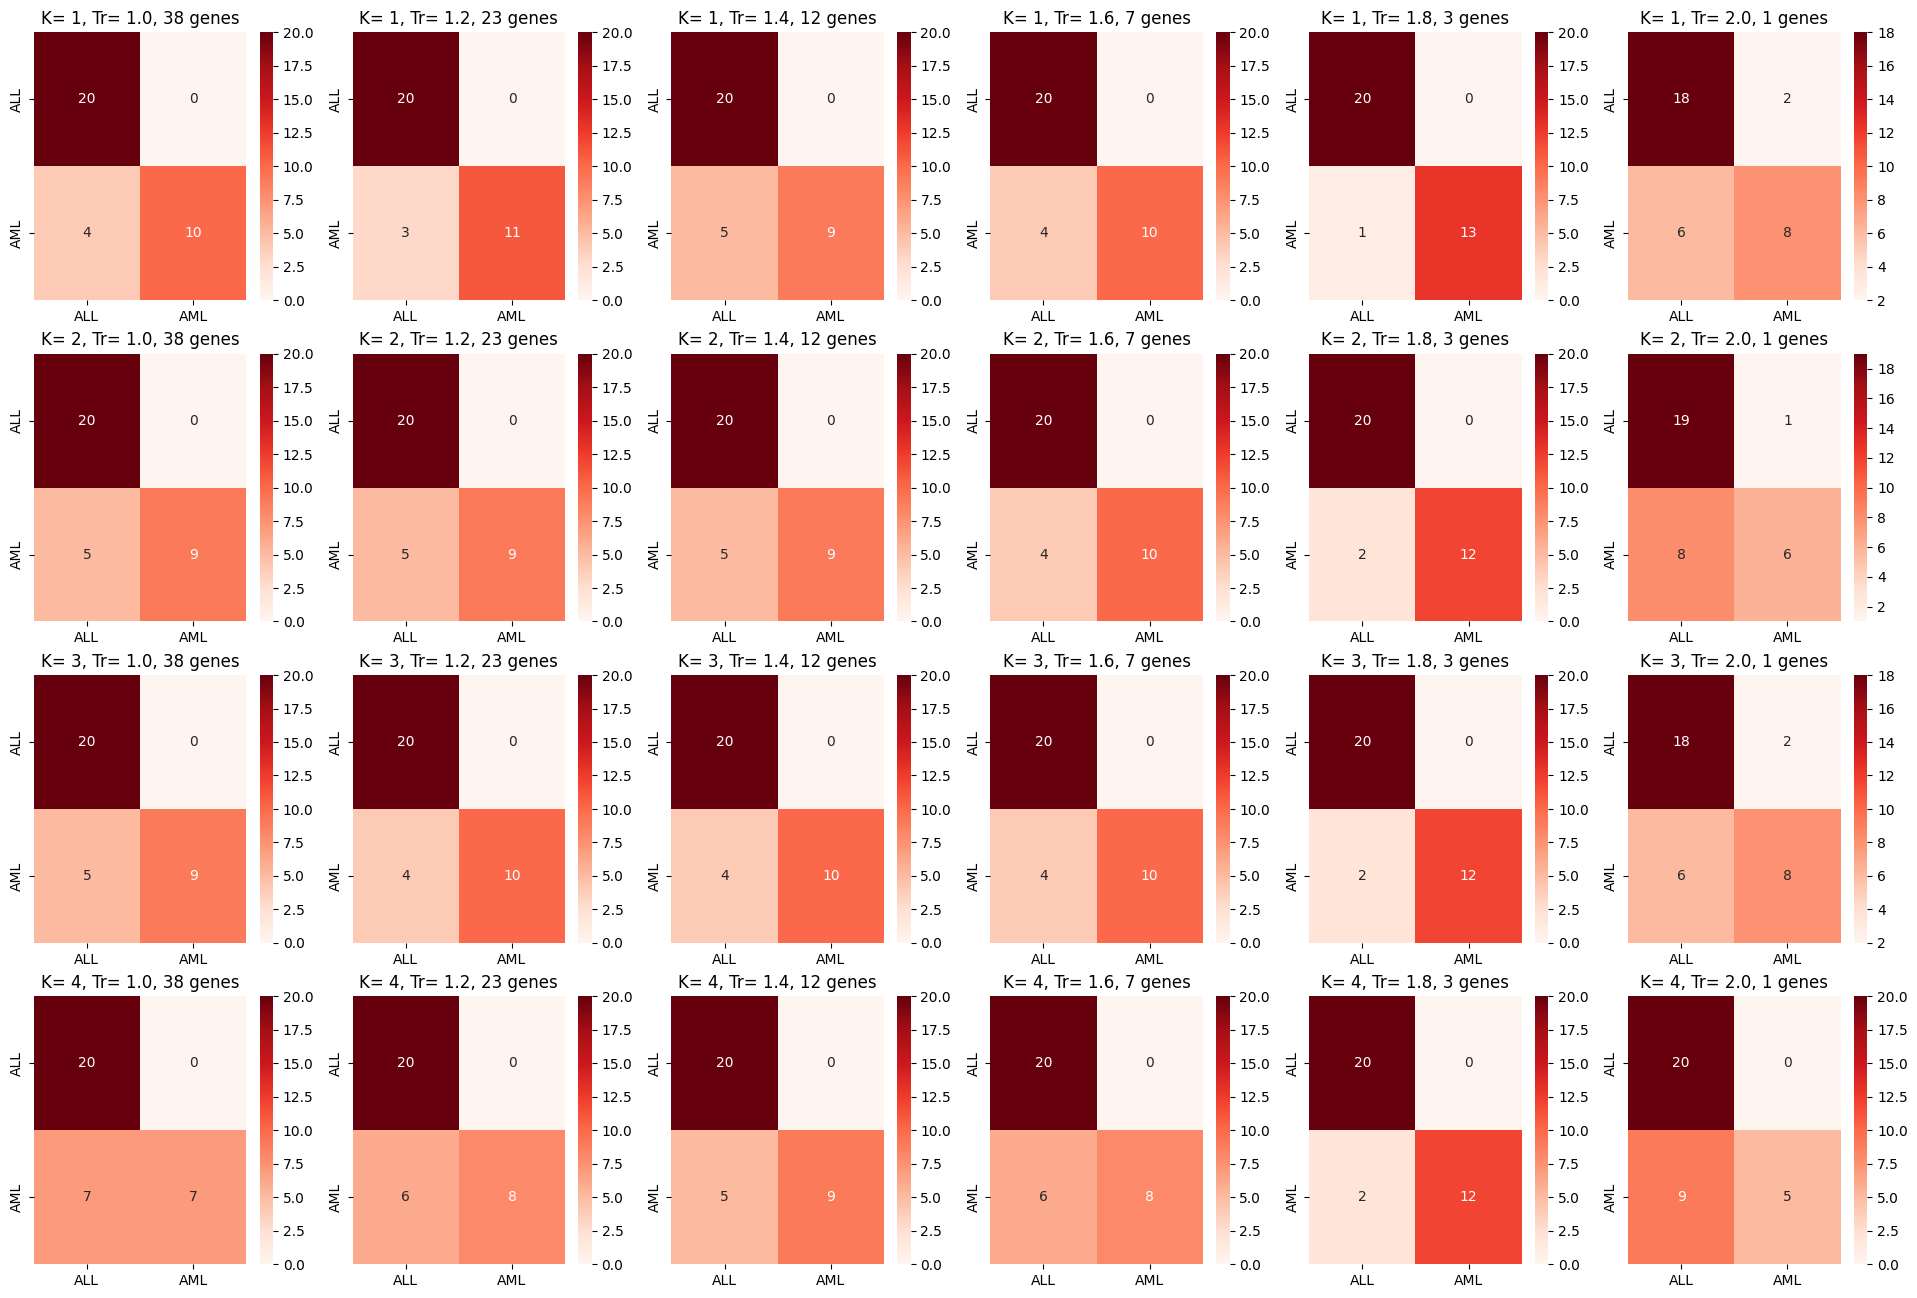

In [16]:
x=4
y=6
p_val = 0.001
list_of_candidates = []

fig, ax = plt.subplots(nrows=x, ncols=y, figsize=(24, 16))
counter = 0
for k in range (x):
    for j in range(y):
        threshold = 1+(j*0.2)

        comparisons = compare_median(df_ALL_tr, df_AML_tr)
        candidates_knn = []
        AML_coordinates = []
        ALL_coordinates = []
        for i in range(len(comparisons)):
            if comparisons[i] >= threshold:
                if get_t_value(df_ALL_tr, df_AML_tr, i) <= p_val:
                    candidates_knn.append(i)
        genelists_train = make_genelists(ALL_train, AML_train, df_ALL_tr_norm, df_AML_tr_norm, candidates_knn)
        genelists_test = make_genelists(ALL_indep, AML_indep, df_ALL_test_norm, df_AML_test_norm, candidates_knn)
        dfX, y_tr = make_Y_X_df(genelists_train[0], genelists_train[1],ALL_train, AML_train )
        dfXtest, Y_test = make_Y_X_df(genelists_test[0], genelists_test[1],ALL_indep, AML_indep )

        dfX, y_tr = make_Y_X_df(genelists_train[0], genelists_train[1],ALL_train, AML_train )
        knn = KNeighborsClassifier(n_neighbors=k+1)
        knn.fit(dfX, y_tr)
        Y_pred = knn.predict(dfXtest)
        cm = confusion_matrix(Y_test, Y_pred)
        list_of_candidates.append(candidates_knn)
        illustrate_conf_matrix(cm, ax[k,j], f"K= {k+1}, Tr= {threshold:.1f}, {len(candidates_knn)} genes")
        

**Fig 12**

### Below is the gene lists corressponding to each threshold values. 

In [17]:
found_len = []
for cand in list_of_candidates:
    l = len(cand)
    if l not in found_len:
        found_len.append(l)
        print(f"The length of the gene list: {l}\n")
        for gene in cand:
            print (gene, fetch_name(df_train, gene, 2))
        print("\n-------------------------------------------\n")
        

The length of the gene list: 38

311 ('NADPH-flavin reductase', 'D26308_at')
378 ('AARS Alanyl-tRNA synthetase', 'D32050_at')
759 ('CYSTATIN A', 'D88422_at')
921 ('Nuclear Factor Nf-Il6', 'HG3494-HT3688_at')
1119 ('SNRPN Small nuclear ribonucleoprotein polypeptide N', 'J04615_at')
1132 ('CATHEPSIN G PRECURSOR', 'J04990_at')
1778 ('MPO Myeloperoxidase', 'M19507_at')
1828 ('PPGB Protective protein for beta-galactosidase (galactosialidosis)', 'M22960_at')
1881 ('CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage)', 'M27891_at')
2042 ('LGALS3 Lectin; galactoside-binding; soluble; 3 (galectin 3) (NOTE: redefinition of symbol)', 'M57710_at')
2120 ('CTSD Cathepsin D (lysosomal aspartyl protease)', 'M63138_at')
2287 ('DF D component of complement (adipsin)', 'M84526_at')
2353 ('CCND3 Cyclin D3', 'M92287_at')
2393 ('PLCB2 Phospholipase C; beta 2', 'M95678_at')
2401 ('Azurocidin gene', 'M96326_rna1_at')
2641 ('MB-1 gene', 'U05259_rna1_at')
3251 ('GLUTATHIONE S-TRANSFERASE; MICROSOMAL', 

# Metaanalysis

To date, 101 kaggle notebooks were published and labelled as related to this dataset. Some are empty or in fact unrelated. Majority of the datasets does not contain any gene name. Many are copies of each other and do the exact same steps with the exact same results, apparently as a part of a data analysis curriculum/homework. 

Some do suggest genes but in a low-resolution figure from which the extraction of gene names failed. Models that contain gene suggestions but are a copies of another models, were excluded. Other than these falling into the listed exclusion criteria, each model was included. More details on each notebook and the reason of exclusion can be found in Appendix 2. 

In this work, kaggle models are referred to as M1 to M10. The following table contains the link to each model and the number of genes named in that model.

|Model name|Description/link|Candidate genes|
|-|-|-|
|Golub et al |The original paper|100|50|
|M1|https://www.kaggle.com/code/uom190715f/notebooke1852da02f |30|
|M2|https://www.kaggle.com/code/kalinduperera/bioinformatics-microarray-assignment |20|
|M3|https://www.kaggle.com/code/daniillitvinov/cancer-types-classification |20|
|M4|https://www.kaggle.com/code/selinyang/gene-expression-data-for-acute-leukemia-patients |34|
|M5|https://www.kaggle.com/code/giuliapais/leveraging-random-forest-for-leukemia-typing |20|
|M6|https://www.kaggle.com/code/ishaanash/tumor-classification-pca |15|
|M7|https://www.kaggle.com/code/borodor/classifier-for-two-cancer-types |6|
|M8|https://www.kaggle.com/code/gonnel/who-is-at-risk-of-cancer-a-simple-analysis |9 of 10*|
|M9|https://www.kaggle.com/code/janangakalawana/notebookb4bd52654e |40|
|M10|https://www.kaggle.com/code/sangeeta97/cancer-type-gen |10|
|This work| (this work) |38|

                *M8 contained 10 genes but only 9 was readable.


The total of over 300 gene suggestions contained many overlaps, the final number of candidate genes is around 200. The following table contains all the genes sorted by the number of models that list the given gene. The top genes were suggested by 7 models out of 12. Model 9 had 3 sub-models resulting in different, but overlapping gene sets. For the purpose of this work, the three sub-models are handled as one, but showing the submodels in brackets. I.e. if a gene was recommended by submodels 1 and 3, the table shows M9(1&3) and so on. 

## Important notes in advance.
* Column 1 is a warning column. If it contains three exclamation marks (!!!) it means that those genes are orherwise excluded from this work because of their unreliably low signal levels. 
* The index column represents the gene index in the original dataframe.
* Some genes are present on the Affymetrix chip in multiple copies. Such as Lyzozyme or Interleukin-8. Some models suggested one copy of the gene, other models picked up another copy or even multiple copies. Such genes were merged as follows:
 - At the index row, all indices are shown such as 6199, 6200. 
 - At the end of the gene name, all GenBank ID numbers are shown in the same order as the indices such as  (M28130, Y00787)
 - in the model columns, a bracket shows the index of the copy found. For example "M1 \[#6199\]" means that Model1 found the interleukin gene version at index 6199; "M6 \[both\]" means that Model6 found both copies. 
 - The column "group similarity" shows a percentage value of the expression pattern similarity within the same-gene group (i.e. how the pattern of the first interleukin-8 copy is similar to the pattern of the other copy). This is expected to be high, and in some cases it indeed is. Some genes show low similarity to their own other copies, perhaps due to low general expression levels in those genes. 
* The column called hits shows the number of models listing that gene.
* The rest of the columns organize each model as listed above and shows which model found which gene. 
* Each gene was manually checked using the GenBank ID. The names were confirmed, shortened / abbreviated / fixed, in some cases a better-known-as synonym was selected instead of the originally listed name. 
* In some cases unfortunately the listed GenBank ID did not match the gene name (or any synonym). These genes were marked in a bracket either with "annotation issue", or a remark or hint on what could be found. Some were fixed using Broad Institute's mapping supplement from this link: 
https://pubs.broadinstitute.org/mpr/projects/Metastasis/Mets_Supplement_Information_041110_KR.xls

### 

|warning|index | gene (id)|hits|Group similarity|Golub et al |M1|M2|M3|M4|M5|M6|M7|M8|M9|M10|This work|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
||1881 |  CST3 Cystatin C (M27891)|7||Golub et al|M1|M2|M3|||M6|||M9(1&3)||This work|
||4846 |  Zyxin (X95735)|7||Golub et al|M1|M2|M3||||M7||M9(1&3)||This work|
||6199, 6200 |  Interleukin 8 (M28130, Y00787)|5|95%+|Golub et al \[both\]|M1 \[#6199\]|||||M6 \[both\]|||M9(1&3) \[#6199\]||This work \[both\]|
||2401 |  Azurocidin (M96326)|5||Golub et al|M1|||||M6|||M9(1)||This work|
||1778 |  MPO Myeloperoxidase (M19507)|4|||M1|||||M6|||M9(1&3)||This work|
||2120 |  CTSD Cathepsin D (M63138)|4||Golub et al|M1||||||||M9(1&3)||This work|
||2641 |  MB-1 (U05259)|4||Golub et al|M1||||||||M9(2&3)||This work|
||2019 |  FAH Fumarylacetoacetate (M55150)|4||Golub et al||M2|M3||||M7|||||
||3319 |  Leukotriene C4 synthase LTC4S (U50136)|4||Golub et al|||M3|M4|||M7|||||
||2287 |  Adipsin (M84526)|3||Golub et al|||||||||M9(1&3)||This work|
||4051 |  Catalase (X04085)|3||Golub et al|M1||||||||M9(1&3)|||
||2042 |  IgE (M57710)|3||Golub et al|||||||||M9(1)||This work|
||311 |  NADPH-flavin reductase (D26308)|3|||M1||||||||M9(1)||This work|
||3251 | MGST1 (U46499)|3||||M2|M3||||||||This work|
||4327 |  Proteosome Iota /PROS-27  (X59417)|3||Golub et al||||M4|||||M9(2)|||
||5038 | LEPROT (Y12670)|3||Golub et al|||||||M7||||This work|
||5771 |  C-myb (U22376)|3||Golub et al|M1||||||||M9(2)|||
||5975, 6796, 6802 | LYZ Lysozyme (M21119, J03801, M19045)|3|95%+|Golub et al \[#6802\]|M1 \[#6796\]||||||||||This work \[#5975\]|
||1303 |  Mac-2 binding protein (L13210)|2|||M1||||||||M9(1&3)|||
||1692 |  IgJ  (M12759)|2|||M1||||||||M9(2&3)|||
||2348 | Kazal-type serine proteinase HUSI-II (M91438)|2|||M1||||||||M9(1&3)|||
||2393 |  PLCB2 Phospholipase C (M95678)|2|||||||||||M9(1&3)||This work|
||5951 |  Glycophorin HeP2 (U05255)|2|||M1||||||||M9(1&3)|||
||6400 |  ID2 Inhibitor of DNA binding 2 (M97796)|2|||M1||||||||M9(2&3)|||
||6538 |  Epb72  (X85116)|2||Golub et al|||||||||M9(1&3)|||
||6883 | Beta-globin (U01317)|2||||||||M6|||M9(1&3)|||
||1248 |  MCL1 (L08246)|2||Golub et al|M1|||||||||||
||1744 |  LYN V-yes-1 (M16038)|2||Golub et al|||M3|||||||||
||1828 |  PPGB Protective protein \[Cathepsin A\] (M22960)|2|||M1||||||||||This work|
||1833 |  CD33 (M23197)|2||Golub et al|||||||M7|||||
||1925 |  PTX3 / TSG-14  (M31166)|2||||M2|M3|||||||||
||1927 |  Oncoprotein 18 Op18 (M31303)|2||Golub et al||||M4||||||||
||2060 |  NK4  (M59807)|2|||M1||||||||M9(2)|||
||2110 |  ATP6C Vacuolar H+ ATPase proton channel subunit (M62762)|2||Golub et al|||||||||M9(1)|||
||2185 |  MAD3 (M69043)|2||Golub et al||||||M6||||||
||2241 |  hCyP3 (M80254)|2||Golub et al||||M4||||||||
||2344 |  G-gamma globin / A-gamma globin (M91036)|2|||M1|||||M6||||||
||2347 |  ACADM  / MCAD (M91432)|2||Golub et al||||M4||||||||
||2353 |  Cyclin D3 (M92287)|2||Golub et al|||||||||||This work|
||2908 |  SRP9 (U20998)|2||Golub et al||||M4||||||||
||378 | AARS Alanyl-tRNA synt. (D32050)|2||||||M4|||||||This work|
||4195 |  PRG1 Proteoglycan 1 ( X17042)|2||Golub et al||||M4||||||||
||4534 |  RbAp48 / Nurf55 / Lin-53 (X74262)|2||Golub et al||||M4||||||||
||5190 |  Adenosine triphosphatase; calcium (Z69881)|2||Golub et al|||||||||M9(2)|||
||5253 |  MCM3 / hRlf3 / p102  (D38073)|2||Golub et al||||M4||||||||
||5500 |  TOP2B (Z15115)|2||Golub et al||||M4||||||||
||5551 |  orphan G-protein coupled R / CD184 (L06797)|2|||M1||||||||M9(2)|||
||5709 | Beta-globin (M25079, HG1428-HT1428)|2||||||||M6 \[both\]||M8 \[both\]||||
||6217 |  ELA2 Elastatse 2; neutrophil (M27783)|2|||M1||M3|||||||||
||6280 |  MYL1 Myosin light chain (M31211)|2||Golub et al||||M4||||||||
||6372 |  ITGAX aka CD11C (M81695)|2||Golub et al|||||||||||This work|
||6375 |  PFC Properdin P factor; complement (M83652)|2||Golub et al|||M3|||||||||
||6514 |  DHPS Deoxyhypusine synthase (U26266)|2||Golub et al||||M4||||||||
||759 |  CYSTATIN A (D88422)|2|||||M3||||||||This work|
||5933, 5934 |  MT2 Metallothionein isoform 2 (V00594, twice)|2|90%+|||||||||M8 \[#5934\]|M9(2) \[#5933\]|||
||6282, 6854 | TCF3 / HE47 / E2A IGEBF E12-E47 (M65214, M31523)|2|48%|Golub et al \[#6854\]|||||||||||This work \[#6282\]|
||1810 |  4F2 heavy chain antigen / CD98HC (M21904)|1|||||||||||M9(1&3)|||
||5087 |  HSPB1 Heat shock 27kD protein 1 (Z23090)|1|||||||||||M9(2&3)|||
||5687 |  CD24 signal transducer (L33930)|1|||||||||||M9(2&3)|||
||7065 |  PRSS1 / trypsin 1 / TRP1 (M22612)|1|||||||||||M9(1&3)|||
||1070 |  Sp1 transcription factor (J03133)|1||||M2||||||||||
||1108 |  \[annotation issue #1108\]* (J04164)|1|||||||||||M9(2)|||
||1119 |  snRNP polypept. N. (J04615)|1|||||||||||||This work|
||1132 |  CATHEPSIN G PRECURSOR (J04990)|1|||||||||||||This work|
|!!!|1186 |  GSTM5 Glutathione S-transferase M5 (L02321)|1||||M2||||||||||
||1221 |  RPL37A Ribosomal protein L37a (L06499)|1||||||||||M8||||
|!!!|1239 | DHP sensitive Ca channel, gamma (L07738)|1|||||M3|||||||||
||1259 |  LAMP2 (L09717)|1||||||M4||||||||
|!!!|1284 |  Protocadherin 42 (L11369)|1||||||||||||M10||
|!!!|1305 |  CRYZ Crystallin zeta quinone reductase (L13278)|1||||||M4||||||||
|!!!|1348 |  Zinc finger protein (L16896)|1||||||||||||M10||
||1393 |  FTH1 Ferritin heavy chain (L20941)|1||||||||M6||||||
||1462 |  SLC16A1 (L31801)|1|||||||M5|||||||
|!!!|148 | LDLRAD4 (AF009426)|1||||||M4||||||||
||1629 |  Inducible protein (L47738)|1||Golub et al||||||||||||
||1637 |  G0S3 (L49169)|1|||||||||||M9(1)|||
||1673 |  FTL1 Ferritin; light polypeptide (M11147)|1||||||||M6||||||
|!!!|1701 |  CP Ceruloplasmin ferroxidase (M13699)|1||||||||||||M10||
||1703 |  ADA Adenosine deaminase (M13792)|1||Golub et al||||||||||||
||172 |  PRKCD Protein kinase C; delta (D10495)|1|||||M3|||||||||
||1764 |  RPLP0 Ribosomal protein; large; P0 (M17885)|1||||||||||M8||||
||18 |  hum_alu_at miscellaneous control (hum_alu_at)|1||||||||||M8||||
|!!!|1808 |  TCRD T-cell receptor; delta (M21624)|1|||M1|||||||||||
||1817 |  HSPD1 Heat shock 60 kD protein 1 chaperonin (M22382)|1|||||||||||M9(2)|||
||1829 |  CYB5 Cytochrome b-5 (M22976)|1|||||||M5|||||||
|!!!|1858 | Kallikrein (M25629)|1|||||||M5|||||||
||1902 |  Translational initiation factor 2 beta subunit elF-2-beta (M29536)|1||||||M4||||||||
||1908 |  IL7R Interleukin 7 receptor (M29696)|1||Golub et al||||||||||||
||1928 |  GNB3 Guanine nucleotide binding protein G protein; beta (M31328)|1|||||||M5|||||||
|!!!|1983 |  CO-029 (M35252)|1||||||||||||M10||
|!!!|1986 |  FUT1 Fucosyltransferase 1 galactoside 2-alpha-L-fucosyltransferase (M35531)|1|||||||M5|||||||
||1998 | CTLA-4 (M37245)|1|||||||M5|||||||
||2009 |  CD9 antigen (M38690)|1|||||||||||M9(2)|||
||2014 |  PPBP Connective tissue activation peptide III (M54995)|1|||||M3|||||||||
||2057 |  TNFAIP1 (M59465)|1|||M1|||||||||||
|!!!|2112 |  SSA1 Sjogren syndrome antigen A1 52kD, SS-A/Ro (M62800)|1|||||||M5|||||||
|!!!|2266 |  CDC25A (M81933)|1|||||M3|||||||||
||2268 | ELF-1 (M82882)|1||||M2||||||||||
|!!!|2317 |  RFC2 Replication factor C activator 1 2; 40kD subunit  (M87338)|1|||||||M5|||||||
|!!!|2334 |  IGB Immunoglobulin-associated beta B29 (M89957)|1|||M1|||||||||||
|!!!|2360 |  CTGF Connective tissue growth factor (M92934)|1|||||||||||M9(2)|||
||2364 |  INSM1 (M93119)|1|||||||M5|||||||
||2371 |  PTPRZ Protein tyrosine phosphatase; receptor-type; zeta polypeptide (M93426)|1||||M2||||||||||
||2372 |  Paired box gene PAX6 homologue (M93650)|1||||M2||||||||||
|!!!|2373 |  NOS3 Nitric oxide synthase 3 (M93718)|1||||M2||||||||||
|!!!|2374 |  DHODH Dihydroorotate dehydrogenase (M94065)|1||||M2||||||||||
|!!!|2375 |  LOR Loricrin (M94077)|1||||M2||||||||||
|!!!|2376 |  Cadherin-associated protein CTNNA2 (M94151)|1||||M2||||||||||
|!!!|2377 |  HGL Heregulin alpha (M94167)|1||||M2||||||||||
|!!!|2384 | Recombination acitivating protein RAG2 (M94633)|1||||M2||||||||||
|!!!|2385 | PA-FABP (M94856) |1||||M2||||||||||
||2390 |  COL9A2 Collagen; type IX; alpha 2 (M95610)|1||||M2||||||||||
||2391 |  PBGD hydroxymethylbilane synthase (M95623)|1||||M2||||||||||
||2440 |  HKR-T1  (S50223)|1||Golub et al||||||||||||
||247 |  ADM Adrenomedullin (D14874)|1|||||M3|||||||||
||2515 | Mrg / mas-L (S78653)|1|||||||M5|||||||
||2640 |  Fetal Alz-50-reactive clone 1 FAC1 (U05237)|1||||||M4||||||||
||2700 |  PINCH protein mRNA (U09284)|1|||||||M5|||||||
||2885 |  Transmembrane protein (U19878)|1||||||M4||||||||
|!!!|3016 |  Splicing factor SRp55-2 (U30828)|1||||||M4||||||||
||3055 |  Cytoplasmic dynein light chain 1 hdlc1 (U32944)|1||Golub et al||||||||||||
||3095 |  Heterochromatin protein p25 (U35451)|1||Golub et al||||||||||||
|!!!|3178 |  PRELP Proline arginine-rich end leucine-rich repeat protein (U41344)|1||||||||||||M10||
||321 |  Proteasome subunit HsC10-II (D26598)|1|||M1|||||||||||
||3253 |  Tetratricopeptide repeat protein /TPR1, TTC1/ (U46570)|1|||||||||||||This work|
||3257 |  Phosphotyrosine independent ligand p62 for the Lck SH2 domain (U46751)|1||Golub et al||||||||||||
|!!!|3300 |  Canalicular multispecific organic anion transporter cMOAT (U49248)|1||||||M4||||||||
|!!!|3334 |  Betaine-homocysteine methyltransferase (U50929)|1||||||||||||M10||
|!!!|3339 |  Homeobox protein Cdx2 (U51096)|1||||M2||||||||||
||3370 |  RNA pol II seventh subunit rpb-7 (U52427)|1|||||||M5|||||||
||3425 |  Myelodysplasia/myeloid leukemia factor 2 MLF2 (U57342)|1|||||||M5|||||||
|!!!|3665 |  C3f (U72515)|1||||||||||||M10||
||3709 |  LITAF (U77396)|1|||||||||||||This work|
|!!!|3800 |  Huntingtin interacting protein HIP1 (U79734)|1||||||M4||||||||
||3846 | Homeodomain protein HoxA9 (U82759)|1||Golub et al||||||||||||
||40 |  18s rRNA (M10098)|1|||||||||||M9(2)|||
||4029 |  SOD1 Superoxide dismutase 1 Cu/Zn (X02317)|1|||M1|||||||||||
||411 |  KIAA0084 (D42043)|1|||||||||||M9(2)|||
||414 |  KIAA0083 (D42046)|1|||||||M5|||||||
||4141 |  CD37 antigen (X14046)|1||||||M4||||||||
|!!!|4176 |  IRF2 Interferon regulatory factor 2 (X15949)|1||Golub et al||||||||||||
|!!!|4199 |  GATA1 / Eryf1 (X17254)|1|||||||M5|||||||
||4210 |  VIL2 Villin 2 ezrin (X51521)|1|||||||||||M9(2)|||
|!!!|4232 |  ERCC2 (X52221)|1|||||||M5|||||||
||4365 |  ARHG Ras homolog gene family; member G /rho G/ (X61587)|1|||||||||||||This work|
||4372 | GRN Granulin (X62320)|1|||||||||||||This work|
||4388 |  GTF2E2 / TFIIE beta subunit; 34 kD (X63469)|1||Golub et al||||||||||||
|!!!|4429 |  CMRF35 (X66171)|1||||||M4||||||||
||4498 |  CHRNA7 Cholinergic receptor; nicotinic; alpha polypeptide 7 (X70297)|1|||||M3|||||||||
||45 |  Beta actin (X00351)|1||||||||||M8||||
|!!!|4514 |  ENG Endoglin Osler-Rendu-Weber syndrome 1  (X72012)|1||||||||||||M10||
|!!!|4582 | MT1,  MT1L Metallothionein 1L (X76717)|1|||||||M5|||||||
||460 |  Interferon-gamma inducing factor IGIF / IL-18 (D49950)|1|||||||||M7|||||
|!!!|4660 |  Biphenyl hydrolase-related protein (X81372)|1||||||M4||||||||
|!!!|4670 |  GENX-5624 (X81895)|1|||||||M5|||||||
||4709 |  ACYLPHOSPHATASE ACYP1  (X84194)|1||||||M4||||||||
||4779 |  Uridine phosphorylase (X90858)|1|||||M3|||||||||
||4780 |  Gp25L2 protein (X90872)|1||||||M4||||||||
||4920 |  TPRC / RCCP1 (X99720)|1|||||||M5|||||||
||4935 |  GPX1 / GPXD Glutathione peroxidase 1 (Y00433)|1||||||||M6||||||
||4950 |  Nucleoside-diphosphate kinase (Y07604)|1|||M1|||||||||||
||4972 |  17p13.2 \[RABAPTIN-5 or Nup88?\]*  (Y08612)|1||Golub et al||||||||||||
||5008 |  SIRP-beta1 (Y10376)|1|||||||||||||This work|
||5101 |  \[annotation issue #5101\]*  (Z26876)|1|||||||M5|||||||
|!!!|514 |  Platelet activating factor acetylhydrolase IB gamma-subunit (D63391)|1||||||M4||||||||
||5198 |  Mitochondrial 16S rRNA ( Z70759)|1||||||||||M8||||
||5228 | \[contig with alpha or zeta globin\] (Z84721)|1||||||||M6||||||
||531 |  HMG1 High-mobility group nonhistone chromosomal protein 1 (D63874)|1||||||M4||||||||
||5351 | Nonmuscle myosin heavy chain-B MYH10 (M69181) |1||||||M4||||||||
|!!!|5401 |  E2F5 E2F transcription factor 5; p130-binding (U31556)|1||||||M4||||||||
||5417 |  DNA-PKcs  (U47077)|1||||||M4||||||||
||5592, 7118 |  Transcriptional activator hSNF2b (D26156, U29175)|1|32%|Golub et al \[both\]||||||||||||
||5641 |  CALM1 Calmodulin 1 phosphorylase kinase; delta (M19311)|1|||||||||||M9(2)|||
||5647 |  HLA-B null allele (D49824)|1||||||||||M8||||
||5793 | LMNA Lamin A (M13452)|1|||||||||||||This work|
||586 |  KIAA0181 gene (D80003)|1|||||M3|||||||||
||5889 |  Dematin (HG4535-HT4940)|1|||||||||||||This work|
||6040 |  APLP2 Amyloid beta A4 precursor-like protein 2 (L09209)|1|||||M3|||||||||
||6182 |  Interleukin 6 (Y00081)|1||||||||||||M10||
||6184 |\[LFA-1 + CD18 cluster\]* (X64072)|1|||||||||||||This work|
||6208 |  VIM Vimentin (Z19554)|1||||||||M6||||||
||6214 |  Human myeloperoxidase gene; ex 1-4 (M19508)|1|||||||||||||This work|
||6264 |  JUNB JunB proto-oncogene (U20734)|1|||||||||||||This work|
||6284 |  Proto-oncogene BCL3 (U05681)|1|||||||||||||This work|
||6307 |  GRO2 oncogene (M57731)|1|||||||||||||This work|
||6313 |  Transforming growth factor-beta (M38449)|1|||||||||||||This work|
|!!!|6586 |  Chromatin structural protein homolog SUPT5H (U56402)|1||||||||||||M10||
||6587 |  Low-Mr GTP-binding protein RAB31 (U59877)|1||||||M4||||||||
||6701 |  LPAP \[aka PTPRCAP or LSM-1\] (X97267)|1|||||||||||||This work|
||673 |  KIAA0219 gene  (D86973)|1|||||M3|||||||||
||6780 | DBI/ACBP1  (X94563)|1|||M1|||||||||||
||6918 |  RNS2 / RAF3 / EDN  (X16546)|1||||||M4||||||||
||803 |  Macmarcks (HG1612-HT1612)|1|||||||||||M9(2)|||
|!!!|920 |  Uncoupling Protein Ucp (HG3492-HT3686)|1|||M1|||||||||||
||921 |  Nuclear Factor Nf-Il6 (HG3494-HT3688)|1|||||||||||||This work|


## Lessons learned

* The number of genes plotted against the number of their "hits" is as follows:


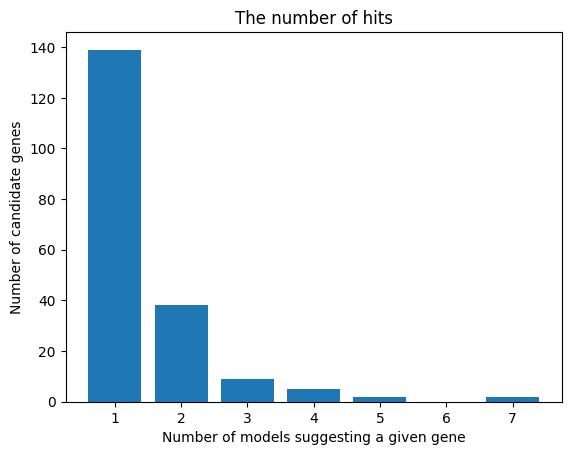

In [18]:
plt.bar([1, 2, 3, 4, 5, 7],[139,38,9,5,2,2])
plt.title("The number of hits")
plt.ylabel("Number of candidate genes")
plt.xlabel("Number of models suggesting a given gene")
plt.show()

* Roughly 70% of the candidate genes were nominated by only one model.
* Only 4 genes were nominated by at least half of the models. 
* M5, M8 and M10 do avoid "popular" genes. Neither of these models propose anything that is nominated by more than 2 other models, meaning that these models share nomination with a maximum of 1 other model. M4 is a bit similar but only avoids the most popular genes. 
* However it does not mean that these models are similar to each other. 
* The models are in general not very similar according to the correlation between them, yet many of them perform at the same levels. 
* Apparently this problem can be successfully approached in different ways. 

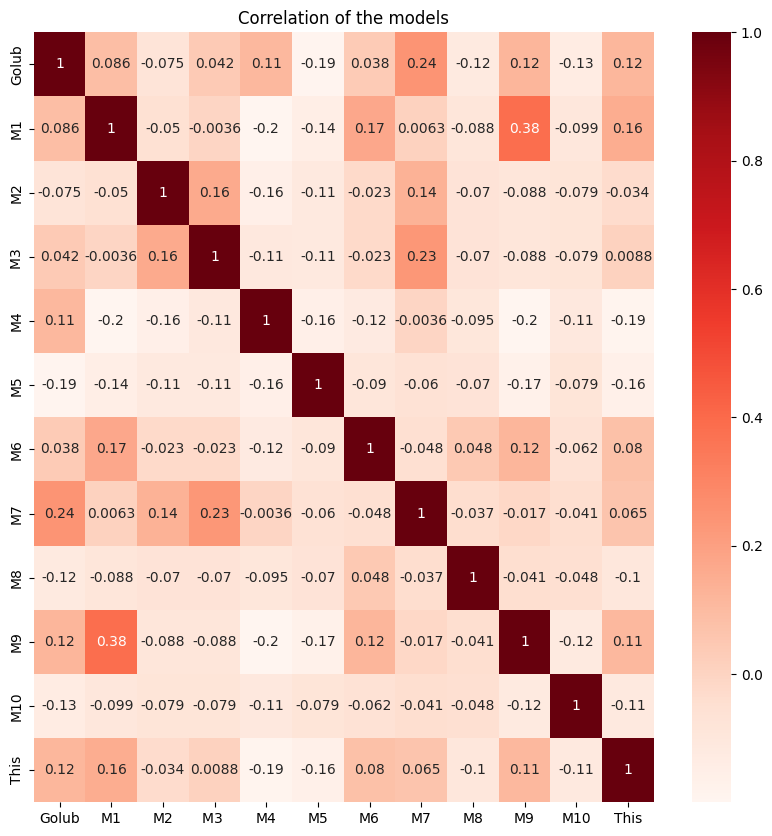

In [19]:
plt.figure(figsize=(10,10))
dataplot = sns.heatmap(df_meta.corr(), cmap="Reds", annot=True) 
plt.title("Correlation of the models")
plt.show()

# 
# CONCLUSIONS

In this work, two distance based classification approaches were tested. The Distance to Mean (DTM) model was implemented from scratch, the k nearest neighbor (KNN) model was imported from the Sklearn modul, and optimized for this problem. Both models use a list of candidate genes, selected from the Affymetrix chip, based on the following criteria:
- The median value of the candidate gene in one of the cancer classes must have certain ratio to the median value in the other class, regardless of which class is higher. 
- The required ratio is an optimizable parameter for both DTM and KNN models. 
- The required ratio is expressed in a logarithmic form called threshold throughout this work, i.e a threshold of 2 would mean 100-fold difference between the mean of the candidate gene in one of the cancer tpyes compared to the mean of the same gene in the other cancer type. 
- At lower thresholds, a secondary limit was used, t-test of the two gene expression values (handled as populations), and a p-value of 0.001 was required. Depending on the threshold setting (that would result in a primary list of candidates), the p-value cut-off results in 0-50% of candidate elimination. The higher the threshold is, the less genes are removed by the secondary limit. 

The results show that the DTM model performs better with lower threshold (the lowest value published here is 1, resulting in 38 genes as parameters in the model). This model flattens the n-dimensional space (where n is the number of genes), and regardless of the original n-dimensions, the problem is always reduced to a 2-dimensional distance, where the cancer class is determined by hich half of the 2-dimensional plane they are. On the contrary, the KNN model prefers a narrow subset of the previous gene set, containing only 3 of the genes. The two models perform similarly, predicting correctly all but 1 cancer cases at their optimums. The KNN model parameter K was also optimized and it performed best at low K values. 

In this work, a correlation based grouping of genes was implemented. As a proof of concept, the correlation tends to group together copies of the same genes, as long as their maximum expression levels are high, but fails to group gene copies when the genes have an overall low expression. This problem was not thoroughly investigated and remained highly speculational. However, when only one member of each group was used in the DTM model, the model performance dropped significantly.

A metaanalysis of all available kaggle notebooks (10, plus the original publication plus this work = 12 total models) revealed that the different solutions result very different gene sets yet comparable outcomes. There are some genes that were suggested by many models, but even the most commonly suggested genes were found by only 7 of the 12 compared models. 


The author is thankful for any future comment or suggestion, especially if the actual name of the approach, called here DTM, is brought to his attention. 


# APPENDIX 1

To visualize what the idea of the median-distance based selection of genes, an example run of the candidate generator function was run below. 
The output is an ordered (largest to smallest) values for some genes that with this setting would make the cut. 
An ideal gene would be a candidate where either line is completely above the other. This would indicate that a givene candidadet gene is always expressing better in one type of cancer than in the other. This would make it a perfect candidate. 

In the picture below, gene \#1684, Terminal transferase appears to be almost as good as possible. 

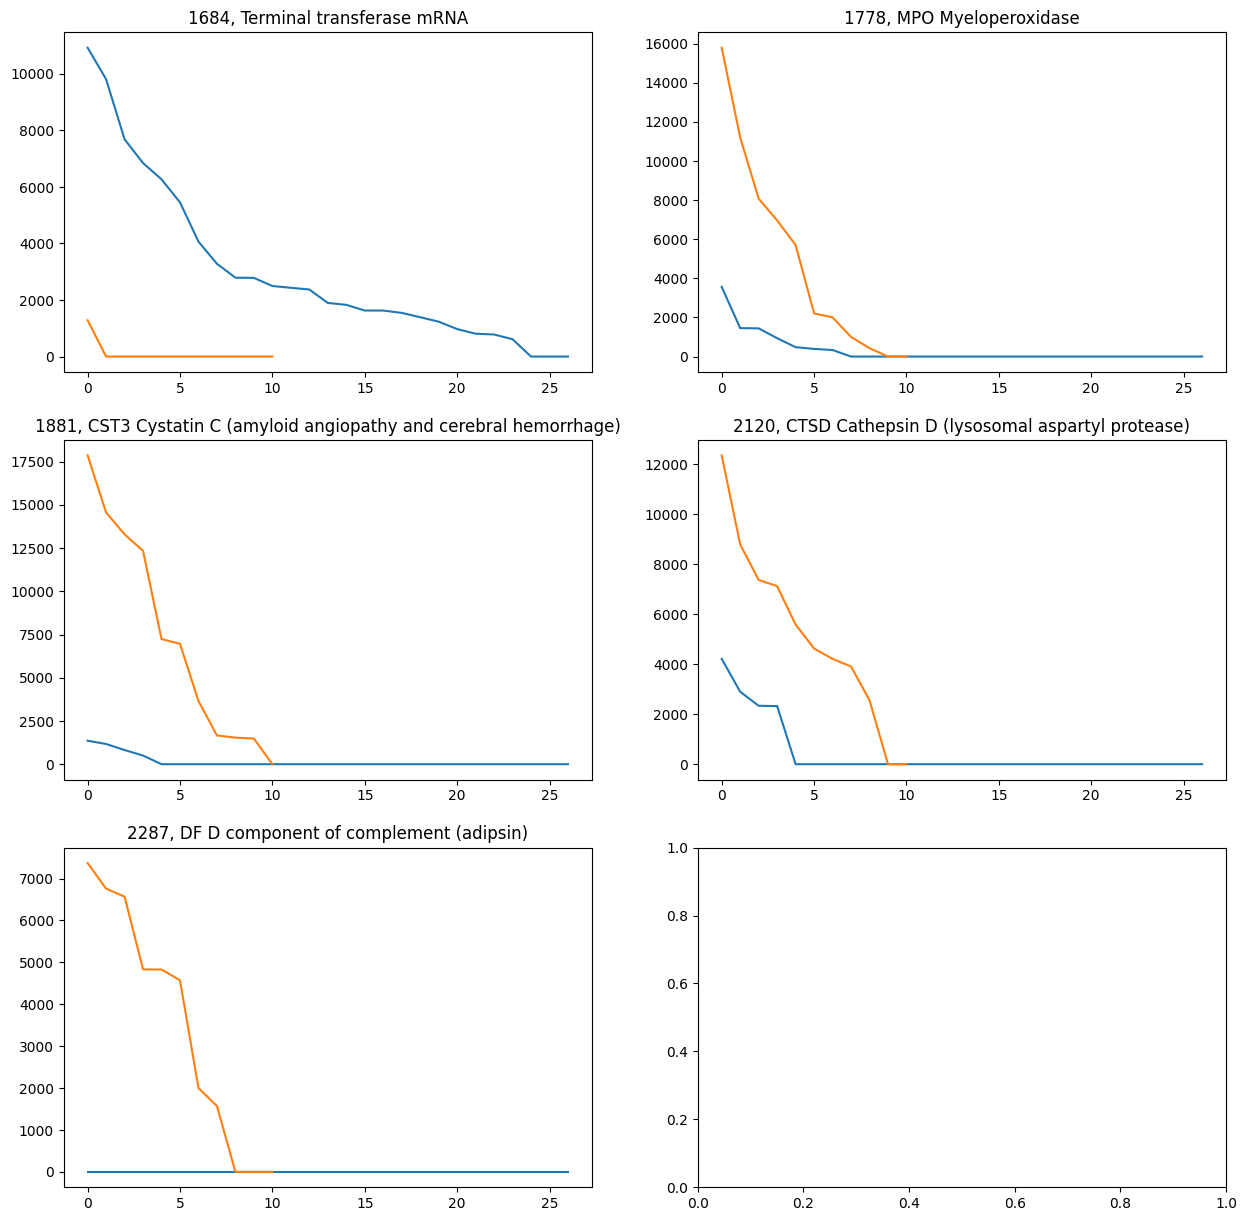

In [20]:
example_candidates = get_candidates(1.7, df_AML_test, df_ALL_test)
m = len(example_candidates)//2+1
n = 2

fig, axs = plt.subplots(m, n, figsize = (15, len(example_candidates)*3))
counter = 0
for i in range(m):
    for j in range(n):
        cand = example_candidates[counter]
        y1 = np.arange(0, len(ALL_train))
        x1 = sorted(df_ALL_tr.loc[cand], reverse = True)
        y2 = np.arange(0, len(AML_train))
        x2 = sorted(df_AML_tr.loc[cand], reverse = True)
        axs[i, j].plot(y1, x1)
        axs[i, j].plot(y2, x2)
        axs[i, j].set_title(f"{cand}, {fetch_name(df_train, cand, 1)}")
        counter +=1
        if counter == len(example_candidates):
            break

***
# APPENDIX 2

Summary of finding models from other kaggle notebooks. 

## All excluded notebooks

The table below shows each checked link ant the reason of excluding them.

|Link |Exclusion criteria|
|-|-|
|https://www.kaggle.com/code/uom190649f/gene-expression-classification|no genes|
|https://www.kaggle.com/code/uom190359p/clustering-and-classification|copy of others|
|https://www.kaggle.com/code/uom190359p/classification|no genes|
|https://www.kaggle.com/code/nitielenaalexandra/pcalaborator|no genes|
|https://www.kaggle.com/code/nitielenaalexandra/lab-pca|no genes|
|https://www.kaggle.com/code/florinmagadan/pca-lab1234567|no genes|
|https://www.kaggle.com/code/popescumihail/pca-geneexpression|no genes|
|https://www.kaggle.com/code/aasthaadhikari/cancer-prediction|no genes|
|https://www.kaggle.com/code/kirillpoltoradnev/gene-classification|no genes|
|https://www.kaggle.com/code/psolomein/notebook473598c161|no genes|
|https://www.kaggle.com/code/thiruiz/an-lise-de-express-o-g-nica|no genes|
|https://www.kaggle.com/code/hasbigumay/classifier-for-two-cancer-types|copy of others|
|https://www.kaggle.com/code/zahrajai/gene-expression-pca-principal-component-analysis|no genes|
|https://www.kaggle.com/code/mehar2/mehar-ml-exp-7|no genes|
|https://www.kaggle.com/code/srivastavamuskan/practical-7|no genes|
|https://www.kaggle.com/code/salman2009/notebookabf24f6e6f|no genes|
|https://www.kaggle.com/code/apoorvshamma/notebookafd47eac44|no genes|
|https://www.kaggle.com/code/kunalraghav/experiment-7-ml|no genes|
|https://www.kaggle.com/code/maedehjadid/question2|no genes|
|https://www.kaggle.com/code/maedehjadid/notebooke316a12b6f|no genes|
|https://www.kaggle.com/code/faezehgharari/classification-of-cancer-using-neural-networks|no genes|
|https://www.kaggle.com/code/maedehjadid/project-2|no genes|
|https://www.kaggle.com/code/nageshsingh/classification-of-cancer|no genes|
|https://www.kaggle.com/code/alexfer/hyperparameter-search-comparison-grid-vs-random|no genes|
|https://www.kaggle.com/code/balasoiuaurelia/pca-geneclassification|no genes|
|https://www.kaggle.com/code/florinactlinaanghel/pca-homework-notebook|no genes|
|https://www.kaggle.com/code/rainbowmiha/all-aml-classification|no genes|
|https://www.kaggle.com/code/djangosheikh/gene-expression-notebook-using-dt-rr|no genes|
|https://www.kaggle.com/code/kidoen/gene-expression-pca-kmeans|no genes|
|https://www.kaggle.com/code/simonecammarasana/notebook98a9d5e987|no genes|
|https://www.kaggle.com/code/kdubey/sparse-linear-svm-is-accurate-and-interpretable|no genes|
|https://www.kaggle.com/code/ashkay/gene-expression-classification|no genes|
|https://www.kaggle.com/code/jasbir98/gene-expression-classification|no genes|
|https://www.kaggle.com/code/acanaceous/gene-expression-classification|no genes|
|https://www.kaggle.com/code/iashwani/gene-expression-classification|no genes|
|https://www.kaggle.com/code/shilpalaksahani/bioinfo-assignement|no genes|
|https://www.kaggle.com/code/afeefsiddique/fork-of-classification-of-cancer|no genes|
|https://www.kaggle.com/code/imharshkashyap/never-touched-python#Project-1:-DNA-Sequence-Analysis-Tool|no genes|
|https://www.kaggle.com/code/nathaliavolpi/gene-expression-classification-rfoptimization|no genes|
|https://www.kaggle.com/code/yangbinggan/gene-expression-classification|no genes|
|https://www.kaggle.com/code/simosrennou/pca-analysis-for-geneclassification|no genes|
|https://www.kaggle.com/code/nanditarahman/r-project-05-golub-et-al-machine-learning|copy of others|
|https://www.kaggle.com/code/mohsenyaaghobi/project2-dl99-00|no genes|
|https://www.kaggle.com/code/andreeadenisastroie/principal-component-analysis|no genes|
|https://www.kaggle.com/code/kaushal99/kaushalexp7|no genes|
|https://www.kaggle.com/code/rishik7619/experiment-7-ml-gene|no genes|
|https://www.kaggle.com/code/damoonshahhosseini/gene-expression|no genes|
|https://www.kaggle.com/code/alexandervc/template-access-multiple-gen-expression-datasets|no genes|
|https://www.kaggle.com/code/shahianshu/gene-expression-classification|no genes|
|https://www.kaggle.com/code/aktemp/gene-expression-classification|no genes|
|https://www.kaggle.com/code/avcbcoder/gene-expression-classification|no genes|
|https://www.kaggle.com/code/ashishlak/gene-expression-classification|no genes|
|https://www.kaggle.com/code/mukulvashisht/kernel1656193e7a|no genes|
|https://www.kaggle.com/code/mrshukla/gene-expression-classification|no genes|
|https://www.kaggle.com/code/pulkitgutpa05/gene-classification-using-pca-analysis|no genes|
|https://www.kaggle.com/code/varimp/gene-expression-classification|no genes|
|https://www.kaggle.com/code/cghiassi5/gene-expression-data-golub-et-al|no genes|
|https://www.kaggle.com/code/dezhijiang/molecule-classification|no genes|
|https://www.kaggle.com/code/dhvandenakker/gene-expression-notebook|no genes|
|https://www.kaggle.com/code/praseeda810/classifier-comparisons-55fce1|no genes|
|https://www.kaggle.com/code/ayanmaity/gene-expression-data-analysis-sn-1-2|no genes|
|https://www.kaggle.com/code/rstogi896/geneclassification-using-gridsearchcv-and-svm|no genes|
|https://www.kaggle.com/code/ayanmaity/gene-expression-data-analysis-using-sn-part-2|no genes|
|https://www.kaggle.com/code/ayanmaity/gene-expression-data-analysis-using-sn|no genes|
|https://www.kaggle.com/code/unfashionable/python-eda|unreadable|
|https://www.kaggle.com/code/crawford/principle-component-analysis-gene-expression|no genes|
|https://www.kaggle.com/code/koohyh/cancer-prediction|no genes|
|https://www.kaggle.com/code/oaoni7/eigengene-pca-analysis-for-cancer-classification|no genes|
|https://www.kaggle.com/code/terenceco/5-day-data-challenge-day-2-r|no genes|
|https://www.kaggle.com/code/terenceco/5-day-data-challenge-day-2-python|no genes|
|https://www.kaggle.com/code/terenceco/5-day-data-challenge-day-1|no genes|
|https://www.kaggle.com/code/asheppard6/5-day-data-challenge-day-2-r|no genes|
|https://www.kaggle.com/code/aschett/5-day-data-challenge-day-2|no genes|
|https://www.kaggle.com/code/rirodrig/5-day-data-challenge-day-2-python|no genes|
|https://www.kaggle.com/code/gfedorov/5-day-data-challenge-day-2|no genes|
|https://www.kaggle.com/code/asheppard6/5-day-data-challenge-day-2-python|no genes|
|https://www.kaggle.com/code/jbacal/5-day-data-challenge-day-1|no genes|
|https://www.kaggle.com/code/windytorgerud/5-day-data-challenge-day-1|no genes|
|https://www.kaggle.com/code/murfog/5-day-data-challenge-day-1|no genes|
|https://www.kaggle.com/code/mgibson23/5-day-data-challenge-day-1|no genes|
|https://www.kaggle.com/code/ebeisaac/5-day-data-challenge-day-2-gene-data|no genes|
|https://www.kaggle.com/code/sanniaf/5day-data-challenge-python|no genes|
|https://www.kaggle.com/code/p4nut4p3/5-day-data-challenge-day-1-python|no genes|
|https://www.kaggle.com/code/superchen/5-day-data-challenge-day-2-learning|no genes|
|https://www.kaggle.com/code/hanlinhuang/gene-expression|no genes|
|https://www.kaggle.com/code/nidafra92/exploring-data|no genes|
|https://www.kaggle.com/code/alonsogutierrez94/classifier-comparisons|copy of others & unreadable|
|https://www.kaggle.com/code/kanav0183/genes-analysis-with-decomposing-and-knn|no genes|
|https://www.kaggle.com/code/kanav0183/pca-analysis-for-geneclassification|no genes|
|https://www.kaggle.com/code/crawford/hyperparameter-search-comparison-grid-vs-random|no genes|
|https://www.kaggle.com/code/vishal86/gene-expression-analysis|no genes|

***

## 1: All gene sets from other models

Below are the models (M1 to M10) and the genes taken out. A link to each model is shown.

### Golub et al


    50 genes

    (5771, C-myb gene extracted from Human (c-myb) gene; complete primary cds; and five complete alternatively spliced cds, U22376_cds2_s_at)
    (4327, PROTEASOME IOTA CHAIN, X59417_at)
    (2641, MB-1 gene, U05259_rna1_at)
    (2353, CCND3 Cyclin D3, M92287_at)
    (6280, MYL1 Myosin light chain (alkali), M31211_s_at)
    (4534, RETINOBLASTOMA BINDING PROTEIN P48, X74262_at)
    (5592, Transcriptional activator hSNF2b, D26156_s_at)
    (2440, HKR-T1, S50223_at)
    (6854, TCF3 Transcription factor 3 (E2A immunoglobulin enhancer binding factors E12/E47), M31523_at)
    (1629, Inducible protein mRNA, L47738_at)
    (3055, Cytoplasmic dynein light chain 1 (hdlc1) mRNA, U32944_at)
    (5500, TOP2B Topoisomerase (DNA) II beta (180kD), Z15115_at)
    (4176, IRF2 Interferon regulatory factor 2, X15949_at)
    (4388, GTF2E2 General transcription factor TFIIE beta subunit; 34 kD, X63469_at)
    (2347, ACADM Acyl-Coenzyme A dehydrogenase; C-4 to C-12 straight chain, M91432_at)
    (7118, Transcriptional activator hSNF2b, U29175_at)
    (5190, Adenosine triphosphatase; calcium, Z69881_at)
    (2908, SRP9 Signal recognition particle 9 kD protein, U20998_at)
    (5253, MCM3 Minichromosome maintenance deficient (S. cerevisiae) 3, D38073_at)
    (6514, DHPS Deoxyhypusine synthase, U26266_s_at)
    (1927, Oncoprotein 18 (Op18) gene, M31303_rna1_at)
    (4972, RABAPTIN-5 protein, Y08612_at)
    (3095, Heterochromatin protein p25 mRNA, U35451_at)
    (1908, IL7R Interleukin 7 receptor, M29696_at)
    (1703, ADA Adenosine deaminase, M13792_at)
    (2019, FAH Fumarylacetoacetate, M55150_at)
    (4846, Zyxin, X95735_at)
    (3319, Leukotriene C4 synthase (LTC4S) gene, U50136_rna1_at)
    (1744, LYN V-yes-1 Yamaguchi sarcoma viral related oncogene homolog, M16038_at)
    (3846, GB DEF = Homeodomain protein HoxA9 mRNA, U82759_at)
    (1833, CD33 CD33 antigen (differentiation antigen), M23197_at)
    (2287, DF D component of complement (adipsin), M84526_at)
    (5038, LEPR Leptin receptor, Y12670_at)
    (1881, CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage), M27891_at)
    (4195, PRG1 Proteoglycan 1; secretory granule, X17042_at)
    (6200, INTERLEUKIN-8 PRECURSOR, Y00787_s_at)
    (2401, Azurocidin gene, M96326_rna1_at)
    (3257, Phosphotyrosine independent ligand p62 for the Lck SH2 domain mRNA, U46751_at)
    (2241, PEPTIDYL-PROLYL CIS-TRANS ISOMERASE; MITOCHONDRIAL PRECURSOR, M80254_at)
    (1248, INDUCED MYELOID LEUKEMIA CELL DIFFERENTIATION PROTEIN MCL1, L08246_at)
    (2110, ATP6C Vacuolar H+ ATPase proton channel subunit, M62762_at)
    (6199, Interleukin 8 (IL8) gene, M28130_rna1_s_at)
    (2120, CTSD Cathepsin D (lysosomal aspartyl protease), M63138_at)
    (2042, LGALS3 Lectin; galactoside-binding; soluble; 3 (galectin 3) (NOTE: redefinition of symbol), M57710_at)
    (2185, MAJOR HISTOCOMPATIBILITY COMPLEX ENHANCER-BINDING PROTEIN MAD3, M69043_at)
    (6372, ITGAX Integrin; alpha X (antigen CD11C (p150); alpha polypeptide), M81695_s_at)
    (6538, Epb72 gene exon 1, X85116_rna1_s_at)
    (6802, LYZ Lysozyme, M19045_f_at)
    (6375, PFC Properdin P factor; complement, M83652_s_at)
    (4051, Catalase (EC 1.11.1.6) 5'flank and exon 1 mapping to chromosome 11; band p13 (and joined CDS), X04085_rna1_at)

### M1 https://www.kaggle.com/code/uom190715f/notebooke1852da02f

    
    30
    
    (2334, IGB Immunoglobulin-associated beta (B29), M89957_at)
    (1778, MPO Myeloperoxidase, M19507_at)
    (1303, Mac-2 binding protein mRNA, L13210_at)
    (311, NADPH-flavin reductase, D26308_at)
    (2348, GB DEF = Kazal-type serine proteinase (HUSI-II) gene, M91438_at)
    (5951, GLYCOPHORIN B PRECURSOR, U05255_s_at)
    (6217, ELA2 Elastatse 2; neutrophil, M27783_s_at)
    (1692, IMMUNOGLOBULIN J CHAIN, M12759_at)
    (6199, Interleukin 8 (IL8) gene, M28130_rna1_s_at)
    (1248, INDUCED MYELOID LEUKEMIA CELL DIFFERENTIATION PROTEIN MCL1, L08246_at)
    (2057, TNFAIP1 Tumor necrosis factor alpha inducible protein A20, M59465_at)
    (2641, MB-1 gene, U05259_rna1_at)
    (4846, Zyxin, X95735_at)
    (5771, C-myb gene extracted from Human (c-myb) gene; complete primary cds; and five complete alternatively spliced cds, U22376_cds2_s_at)
    (6780, Exon 1b; used only in type 2 transcripts from  H.sapiens dbi/acbp gene exon 1 & 2./ntype=DNA /annot=exon, X94563_xpt2_r_at)
    (4029, SOD1 Superoxide dismutase 1 (Cu/Zn), X02317_at)
    (6400, ID2 Inhibitor of DNA binding 2; dominant negative helix-loop-helix protein, M97796_s_at)
    (1881, CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage), M27891_at)
    (2401, Azurocidin gene, M96326_rna1_at)
    (4950, Nucleoside-diphosphate kinase, Y07604_at)
    (2060, NATURAL KILLER CELLS PROTEIN 4 PRECURSOR, M59807_at)
    (1808, TCRD T-cell receptor; delta, M21624_at)
    (2344, G-gamma globin gene extracted from H.sapiens G-gamma globin and A-gamma globin genes's, M91036_rna1_at)
    (4051, Catalase (EC 1.11.1.6) 5'flank and exon 1 mapping to chromosome 11; band p13 (and joined CDS), X04085_rna1_at)
    (1828, PPGB Protective protein for beta-galactosidase (galactosialidosis), M22960_at)
    (2120, CTSD Cathepsin D (lysosomal aspartyl protease), M63138_at)
    (321, Proteasome subunit HsC10-II, D26598_at)
    (6796, LYZ Lysozyme, J03801_f_at)
    (5551, PROBABLE G PROTEIN-COUPLED RECEPTOR LCR1 HOMOLOG, L06797_s_at)
    (920, Uncoupling Protein Ucp, HG3492-HT3686_at)


## M2 https://www.kaggle.com/code/kalinduperera/bioinformatics-microarray-assignment



    20
    
    (4846, Zyxin, X95735_at)
    (2019, FAH Fumarylacetoacetate, M55150_at)
    (1925, PTX3 Pentaxin-related gene; rapidly induced by IL-1 beta, M31166_at)
    (1881, CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage), M27891_at)
    (3251, GLUTATHIONE S-TRANSFERASE; MICROSOMAL, U46499_at)
    (2268, ETS-RELATED TRANSCRIPTION FACTOR ELF-1, M82882_at)
    (1186, GSTM5 Glutathione S-transferase M5, L02321_at)
    (1070, SP1 Sp1 transcription factor, J03133_at)
    (3339, Homeobox protein Cdx2 mRNA, U51096_at)
    (2385, FATTY ACID-BINDING PROTEIN; EPIDERMAL, M94856_at)
    (2384, GB DEF = Recombination acitivating protein (RAG2) gene; last exon, M94633_at)
    (2371, PTPRZ Protein tyrosine phosphatase; receptor-type; zeta polypeptide, M93426_at)
    (2372, Paired box gene (PAX6) homologue, M93650_at)
    (2373, NOS3 Nitric oxide synthase 3 (endothelial cell), M93718_at)
    (2374, DHODH Dihydroorotate dehydrogenase, M94065_at)
    (2391, PBGD gene (hydroxymethylbilane synthase) extracted from Homo sapiens hydroxymethylbilane synthase gene, M95623_cds1_at)
    (2375, LOR Loricrin, M94077_at)
    (2390, COL9A2 Collagen; type IX; alpha 2, M95610_at)
    (2376, Cadherin-associated protein-related (cap-r) mRNA, M94151_at)
    (2377, HGL Heregulin alpha, M94167_at)



### M3 https://www.kaggle.com/code/daniillitvinov/cancer-types-classification




    20 genes
    
    (172, PRKCD Protein kinase C; delta, D10495_at)
    (247, ADM Adrenomedullin, D14874_at)
    (586, KIAA0181 gene; partial cds, D80003_at)
    (673, KIAA0219 gene; partial cds, D86973_at)
    (759, CYSTATIN A, D88422_at)
    (1239, DIHYDROPRYRIDINE-SENSITIVE L-TYPE; SKELETAL MUSCLE CALCIUM CHANNEL GAMMA SUBUNIT, L07738_at)
    (1744, LYN V-yes-1 Yamaguchi sarcoma viral related oncogene homolog, M16038_at)
    (1881, CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage), M27891_at)
    (1925, PTX3 Pentaxin-related gene; rapidly induced by IL-1 beta, M31166_at)
    (2014, PPBP Connective tissue activation peptide III, M54995_at)
    (2019, FAH Fumarylacetoacetate, M55150_at)
    (2266, CDC25A Cell division cycle 25A, M81933_at)
    (3251, GLUTATHIONE S-TRANSFERASE; MICROSOMAL, U46499_at)
    (3319, Leukotriene C4 synthase (LTC4S) gene, U50136_rna1_at)
    (4498, CHRNA7 Cholinergic receptor; nicotinic; alpha polypeptide 7, X70297_at)
    (4779, Uridine phosphorylase, X90858_at)
    (4846, Zyxin, X95735_at)
    (6040, APLP2 Amyloid beta (A4) precursor-like protein 2, L09209_s_at)
    (6217, ELA2 Elastatse 2; neutrophil, M27783_s_at)
    (6375, PFC Properdin P factor; complement, M83652_s_at)


### M4 https://www.kaggle.com/code/selinyang/gene-expression-data-for-acute-leukemia-patients




    34 genes
    
    (3300, Canalicular multispecific organic anion transporter (cMOAT); gene, U49248_at)
    (4534, RETINOBLASTOMA BINDING PROTEIN P48, X74262_at)
    (5253, MCM3 Minichromosome maintenance deficient (S. cerevisiae) 3, D38073_at)
    (5351, GB DEF = Nonmuscle myosin heavy chain-B (MYH10) mRNA; partial cds, M69181_at)
    (1305, CRYZ Crystallin zeta (quinone reductase), L13278_at)
    (4195, PRG1 Proteoglycan 1; secretory granule, X17042_at)
    (378, AARS Alanyl-tRNA synthetase, D32050_at)
    (531, HMG1 High-mobility group (nonhistone chromosomal) protein 1, D63874_at)
    (4660, Biphenyl hydrolase-related protein, X81372_at)
    (2640, Fetal Alz-50-reactive clone 1 (FAC1) mRNA, U05237_at)
    (2241, PEPTIDYL-PROLYL CIS-TRANS ISOMERASE; MITOCHONDRIAL PRECURSOR, M80254_at)
    (6280, MYL1 Myosin light chain (alkali), M31211_s_at)
    (1927, Oncoprotein 18 (Op18) gene, M31303_rna1_at)
    (5417, DNA-dependent protein kinase catalytic subunit (DNA-PKcs) mRNA, U47077_at)
    (3800, Huntingtin interacting protein (HIP1) mRNA, U79734_at)
    (2347, ACADM Acyl-Coenzyme A dehydrogenase; C-4 to C-12 straight chain, M91432_at)
    (4327, PROTEASOME IOTA CHAIN, X59417_at)
    (1259, LAMP2 Lysosome-associated membrane protein 2 {alternative products}, L09717_at)
    (4141, CD37 CD37 antigen, X14046_at)
    (1902, Translational initiation factor 2 beta subunit (elF-2-beta) mRNA, M29536_at)
    (2885, Transmembrane protein mRNA, U19878_at)
    (3016, Splicing factor SRp55-2 (SRp55) mRNA, U30828_at)
    (6587, Low-Mr GTP-binding protein (RAB31) mRNA, U59877_s_at)
    (148, Clone 22 mRNA; alternative splice variant alpha-1, AF009426_at)
    (5401, E2F5 E2F transcription factor 5; p130-binding, U31556_at)
    (2908, SRP9 Signal recognition particle 9 kD protein, U20998_at)
    (4709, ACYLPHOSPHATASE; ORGAN-COMMON TYPE ISOZYME, X84194_at)
    (5500, TOP2B Topoisomerase (DNA) II beta (180kD), Z15115_at)
    (4780, Gp25L2 protein, X90872_at)
    (4429, CMRF35 mRNA, X66171_at)
    (3319, Leukotriene C4 synthase (LTC4S) gene, U50136_rna1_at)
    (514, Platelet activating factor acetylhydrolase IB gamma-subunit, D63391_at)
    (6514, DHPS Deoxyhypusine synthase, U26266_s_at)
    (6918, RNS2 Ribonuclease 2 (eosinophil-derived neurotoxin; EDN), X16546_at)


### M5 https://www.kaggle.com/code/giuliapais/leveraging-random-forest-for-leukemia-typing



    20 genes
    
    (4920, TPRC gene, X99720_rna1_at)
    (1858, GB DEF = Kallikrein mRNA; clone clone phKK25, M25629_at)
    (1998, GB DEF = Ig superfamily cytotoxic T-lymphocyte-associated protein (CTLA-4) gene; last exon, M37245_at)
    (1986, FUT1 Fucosyltransferase 1 (galactoside 2-alpha-L-fucosyltransferase; Bombay phenotype included), M35531_at)
    (3425, Myelodysplasia/myeloid leukemia factor 2 (MLF2) mRNA, U57342_at)
    (3370, RNA polymerase II seventh subunit (rpb-7) gene, U52427_rna1_at)
    (2515, GB DEF = Mrg=mas-related [human; Genomic; 2416 nt], S78653_at)
    (2364, INSM1 Insulinoma-associated 1 (symbol provisional), M93119_at)
    (1829, CYB5 Cytochrome b-5, M22976_at)
    (2112, SSA1 Sjogren syndrome antigen A1 (52kD; ribonucleoprotein autoantigen SS-A/Ro), M62800_at)
    (2317, RFC2 Replication factor C (activator 1) 2; 40kD subunit, M87338_at)
    (1928, GNB3 Guanine nucleotide binding protein (G protein); beta polypeptide 3, M31328_at)
    (5101, LTBP1 Latent transforming growth factor beta binding protein 1, Z26876_at)
    (1462, SLC16A1 Solute carrier family 16 (monocarboxylic acid transporters); member 1, L31801_at)
    (4199, GATA1 Transcription factor Eryf1, X17254_at)
    (414, KIAA0083 gene; partial cds, D42046_at)
    (4582, MT1L Metallothionein 1L, X76717_at)
    (4232, GB DEF = ERCC2 gene; exons 1 & 2 (partial), X52221_at)
    (4670, GB DEF = GENX-5624 mRNA; 3' UTR, X81895_at)
    (2700, PINCH protein mRNA, U09284_at)

### M6 https://www.kaggle.com/code/ishaanash/tumor-classification-pca


    15
    (6200, INTERLEUKIN-8 PRECURSOR, Y00787_s_at)
    (1778, MPO Myeloperoxidase, M19507_at)
    (6208, VIM Vimentin, Z19554_s_at)
    (1881, CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage), M27891_at)
    (5709, GB DEF = Sickle cell beta-globin mRNA, M25079_s_at)
    (2401, Azurocidin gene, M96326_rna1_at)
    (1673, FTL Ferritin; light polypeptide, M11147_at)
    (2344, G-gamma globin gene extracted from H.sapiens G-gamma globin and A-gamma globin genes's, M91036_rna1_at)
    (2185, MAJOR HISTOCOMPATIBILITY COMPLEX ENHANCER-BINDING PROTEIN MAD3, M69043_at)
    (4935, GPX1 Glutathione peroxidase 1, Y00433_at)
    (5228, Alpha-globin 1 gene extracted from Human DNA sequence from cosmid GG1 from a contig from the tip of the short arm of chromosome 16; spanning 2Mb of 16p13.3 Contains alpha and zeta globin genes and ESTs, Z84721_cds2_at)
    (5710, Globin; Beta, HG1428-HT1428_s_at)
    (1393, FTH1 Ferritin heavy chain, L20941_at)
    (6199, Interleukin 8 (IL8) gene, M28130_rna1_s_at)
    (6883, Delta-globin gene extracted from Human beta globin region on chromosome 11, U01317_cds4_at)


### M7 https://www.kaggle.com/code/borodor/classifier-for-two-cancer-types


    6 genes
    
    (5038, 'LEPR Leptin receptor', 'Y12670_at')
    (1833, 'CD33 CD33 antigen (differentiation antigen)', 'M23197_at')
    (4846, 'Zyxin', 'X95735_at')
    (460, 'Liver mRNA for interferon-gamma inducing factor(IGIF)', 'D49950_at')
    (3319, 'Leukotriene C4 synthase (LTC4S) gene', 'U50136_rna1_at')
    (2019, 'FAH Fumarylacetoacetate', 'M55150_at')


### M8 https://www.kaggle.com/code/gonnel/who-is-at-risk-of-cancer-a-simple-analysis





    (5709, 'GB DEF = Sickle cell beta-globin mRNA', 'M25079_s_at')
    (1221, 'RPL37A Ribosomal protein L37a', 'L06499_at')
    (18, 'hum_alu_at (miscellaneous control)', 'hum_alu_at')
    (5710, 'Globin; Beta', 'HG1428-HT1428_s_at')
    (5647, 'GB DEF = HLA-B null allele mRNA', 'D49824_s_at')
    (45, 'AFFX-HSAC07/X00351_M_at (endogenous control)', 'AFFX-HSAC07/X00351_M_at')
    (1764, 'RPLP0 Ribosomal protein; large; P0', 'M17885_at')
    (5934, 'Metallothionein isoform 2', 'V00594_s_at')
    (5198, 'GB DEF = Mitochondrial 16S rRNA gene (partial)', 'Z70759_at')
    Note: the 10th is not visible on any of the figures.


### M9 https://www.kaggle.com/code/janangakalawana/notebookb4bd52654e

Model 9.1 "Positive values"


    20 genes 
    
    (1303, Mac-2 binding protein mRNA, L13210_at)
    (1778, MPO Myeloperoxidase, M19507_at)
    (2393, PLCB2 Phospholipase C; beta 2, M95678_at)
    (4846, Zyxin, X95735_at)
    (6199, Interleukin 8 (IL8) gene, M28130_rna1_s_at)
    (2287, DF D component of complement (adipsin), M84526_at)
    (6538, Epb72 gene exon 1, X85116_rna1_s_at)
    (4051, Catalase (EC 1.11.1.6) 5'flank and exon 1 mapping to chromosome 11; band p13 (and joined CDS), X04085_rna1_at)
    (2348, GB DEF = Kazal-type serine proteinase (HUSI-II) gene, M91438_at)
    (1881, CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage), M27891_at)
    (2120, CTSD Cathepsin D (lysosomal aspartyl protease), M63138_at)
    (5951, GLYCOPHORIN B PRECURSOR, U05255_s_at)
    (6883, Delta-globin gene extracted from Human beta globin region on chromosome 11, U01317_cds4_at)
    (1810, MDU1 Antigen identified by monoclonal antibodies 4F2; TRA1.10; TROP4; and T43, M21904_at)
    (7065, PRSS1 Protease; serine; 1 (trypsin 1), M22612_f_at)
    (2401, Azurocidin gene, M96326_rna1_at)
    (2042, LGALS3 Lectin; galactoside-binding; soluble; 3 (galectin 3) (NOTE: redefinition of symbol), M57710_at)
    (311, NADPH-flavin reductase, D26308_at)
    (2110, ATP6C Vacuolar H+ ATPase proton channel subunit, M62762_at)
    (1637, G0S3 mRNA, L49169_at)


Model 9.2 "Negative values"


    20 genes
    
    (6400, ID2 Inhibitor of DNA binding 2; dominant negative helix-loop-helix protein, M97796_s_at)
    (1692, IMMUNOGLOBULIN J CHAIN, M12759_at)
    (5687, CD24 signal transducer mRNA and 3' region, L33930_s_at)
    (2641, MB-1 gene, U05259_rna1_at)
    (5087, HSPB1 Heat shock 27kD protein 1, Z23090_at)
    (4210, VIL2 Villin 2 (ezrin), X51521_at)
    (5771, C-myb gene extracted from Human (c-myb) gene; complete primary cds; and five complete alternatively spliced cds, U22376_cds2_s_at)
    (5933, Metallothionein isoform 2, V00594_at)
    (40, AFFX-HUMRGE/M10098_3_at (endogenous control), AFFX-HUMRGE/M10098_3_at)
    (5551, PROBABLE G PROTEIN-COUPLED RECEPTOR LCR1 HOMOLOG, L06797_s_at)
    (2009, CD9 CD9 antigen, M38690_at)
    (2060, NATURAL KILLER CELLS PROTEIN 4 PRECURSOR, M59807_at)
    (4327, PROTEASOME IOTA CHAIN, X59417_at)
    (5190, Adenosine triphosphatase; calcium, Z69881_at)
    (1108, RPS3 Ribosomal protein S3, J04164_at)
    (1817, HSPD1 Heat shock 60 kD protein 1 (chaperonin), M22382_at)
    (411, KIAA0084 gene; partial cds, D42043_at)
    (2360, CTGF Connective tissue growth factor, M92934_at)
    (803, Macmarcks, HG1612-HT1612_at)
    (5641, CALM1 Calmodulin 1 (phosphorylase kinase; delta), M19311_s_at)


Model 9.3 "Absolute values"

    
    
 
    20 genes 
    
    (1303, Mac-2 binding protein mRNA, L13210_at)
    (1778, MPO Myeloperoxidase, M19507_at)
    (2393, PLCB2 Phospholipase C; beta 2, M95678_at)
    (4846, Zyxin, X95735_at)
    (6199, Interleukin 8 (IL8) gene, M28130_rna1_s_at)
    (2287, DF D component of complement (adipsin), M84526_at)
    (6538, Epb72 gene exon 1, X85116_rna1_s_at)
    (6400, ID2 Inhibitor of DNA binding 2; dominant negative helix-loop-helix protein, M97796_s_at)
    (4051, Catalase (EC 1.11.1.6) 5'flank and exon 1 mapping to chromosome 11; band p13 (and joined CDS), X04085_rna1_at)
    (1692, IMMUNOGLOBULIN J CHAIN, M12759_at)
    (5687, CD24 signal transducer mRNA and 3' region, L33930_s_at)
    (2348, GB DEF = Kazal-type serine proteinase (HUSI-II) gene, M91438_at)
    (1881, CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage), M27891_at)
    (2120, CTSD Cathepsin D (lysosomal aspartyl protease), M63138_at)
    (5951, GLYCOPHORIN B PRECURSOR, U05255_s_at)
    (2641, MB-1 gene, U05259_rna1_at)
    (6883, Delta-globin gene extracted from Human beta globin region on chromosome 11, U01317_cds4_at)
    (1810, MDU1 Antigen identified by monoclonal antibodies 4F2; TRA1.10; TROP4; and T43, M21904_at)
    (7065, PRSS1 Protease; serine; 1 (trypsin 1), M22612_f_at)
    (5087, HSPB1 Heat shock 27kD protein 1, Z23090_at)

## M10 https://www.kaggle.com/code/sangeeta97/cancer-type-gen


    10 genes 
    
    (4514, ENG Endoglin (Osler-Rendu-Weber syndrome 1), X72012_at)
    (1701, CP Ceruloplasmin (ferroxidase), M13699_at)
    (3334, Betaine:homocysteine methyltransferase mRNA, U50929_at)
    (6182, IL6 Interleukin 6 (B cell stimulatory factor 2), Y00081_s_at)
    (3665, C3f mRNA, U72515_at)
    (6586, Chromatin structural protein homolog (SUPT5H) mRNA, U56402_s_at)
    (1348, Zinc finger protein mRNA, L16896_at)
    (1284, Protocadherin 42 mRNA; 3' end of cds for alternative splicing PC42-8, L11369_at)
    (1983, TUMOR-ASSOCIATED ANTIGEN CO-029, M35252_at)
    (3178, PRELP Proline arginine-rich end leucine-rich repeat protein, U41344_at)



## This work

    38 genes

    (311, NADPH-flavin reductase, D26308_at)
    (378, AARS Alanyl-tRNA synthetase, D32050_at)
    (759, CYSTATIN A, D88422_at)
    (921, Nuclear Factor Nf-Il6, HG3494-HT3688_at)
    (1119, SNRPN Small nuclear ribonucleoprotein polypeptide N, J04615_at)
    (1132, CATHEPSIN G PRECURSOR, J04990_at)
    (1778, MPO Myeloperoxidase, M19507_at)
    (1828, PPGB Protective protein for beta-galactosidase (galactosialidosis), M22960_at)
    (1881, CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage), M27891_at)
    (2042, LGALS3 Lectin; galactoside-binding; soluble; 3 (galectin 3) (NOTE: redefinition of symbol), M57710_at)
    (2120, CTSD Cathepsin D (lysosomal aspartyl protease), M63138_at)
    (2287, DF D component of complement (adipsin), M84526_at)
    (2353, CCND3 Cyclin D3, M92287_at)
    (2393, PLCB2 Phospholipase C; beta 2, M95678_at)
    (2401, Azurocidin gene, M96326_rna1_at)
    (2641, MB-1 gene, U05259_rna1_at)
    (3251, GLUTATHIONE S-TRANSFERASE; MICROSOMAL, U46499_at)
    (3253, Tetratricopeptide repeat protein (tpr1) mRNA, U46570_at)
    (3709, No cluster in current Unigene and no Genbank entry for U77396 (qualifier U77396_at), U77396_at)
    (4365, ARHG Ras homolog gene family; member G (rho G), X61587_at)
    (4372, GRN Granulin, X62320_at)
    (4846, Zyxin, X95735_at)
    (5008, GB DEF = SIRP-beta1, Y10376_at)
    (5038, LEPR Leptin receptor, Y12670_at)
    (5793, LMNA Lamin A, M13452_s_at)
    (5889, Dematin, HG4535-HT4940_s_at)
    (5975, LYZ Lysozyme, M21119_s_at)
    (6184, SELL Leukocyte adhesion protein beta subunit, X64072_s_at)
    (6199, Interleukin 8 (IL8) gene, M28130_rna1_s_at)
    (6200, INTERLEUKIN-8 PRECURSOR, Y00787_s_at)
    (6214, MPO from  Human myeloperoxidase gene; exons 1-4./ntype=DNA /annot=exon, M19508_xpt3_s_at)
    (6264, JUNB Jun B proto-oncogene, U20734_s_at)
    (6282, TCF3 Transcription factor 3 (E2A immunoglobulin enhancer binding factors E12/E47), M65214_s_at)
    (6284, Proto-oncogene BCL3 gene, U05681_s_at)
    (6307, GRO2 GRO2 oncogene, M57731_s_at)
    (6313, Transforming growth factor-beta mRNA; clone pTGF-beta-trp114, M38449_s_at)
    (6372, ITGAX Integrin; alpha X (antigen CD11C (p150); alpha polypeptide), M81695_s_at)
    (6701, LPAP gene, X97267_rna1_s_at)


***
APPENDIX 3: OBSOLETE CODE

This is a cemetery of obsolete code for myself.

    def get_max_dist(length):
        """I was curious how the number of genes ("length") will affect the distances. Not needed anymore."""
        arr0s = [0]*length
        arr1s = [100]*length
        return scipy.spatial.distance.euclidean(arr0s, arr1s)
        
        
        median_distances = []
        
***
    def get_median_cancer(df, gene_arr):
        """Creates an N-dimensional mid-point of a cancer type by adding the median value of each gene to the vector"""
        median_cancer = []  
        for gene in gene_arr:
            median_cancer.append(np.median(df.loc[gene]))
        return median_cancer
***
IN

    for i in range(5, 21):
        candidates_at_thr = []
        thr = i/10
        for j in range(len(gene_med_comparisons)):
            if gene_med_comparisons[j] >= thr:
                if get_t_value(df_ALL_tr, df_AML_tr, j) <=0.8:
                    candidates_at_thr.append(j)

    ALL_med_ = get_median_cancer(df_ALL_tr, candidates_at_thr)
    AML_med_ = get_median_cancer(df_AML_tr, candidates_at_thr)
    median_distances.append(round(get_distance(ALL_med_, AML_med_)/get_max_dist(len(ALL_med_)),3))

    
    print (median_distances)

OUT

    [0.139, 0.156, 0.174, 0.217, 0.239, 0.279, 0.328, 0.369, 0.422, 0.534, 0.564, 0.645, 0.731, 0.833, 1.0, 1.0]
    
***

    def illustrate_distances(corners,L_distances, M_distances):
        #assumes tuples with the corrsponding distamce values
        plt.scatter(L_distances[0], L_distances[1]) 
        plt.scatter(M_distances[0], M_distances[1])
        plt.scatter(corners[0], corners[1])
***
code for generating figure 5 in the methods

    n1 = 759
    n2 =  6184

    plt.plot(df_tr_norm.loc[n1])
    plt.plot(df_tr_norm.loc[n2])
    plt.title(f"Correlation = {get_coeff(df_tr_norm, n1, n2)} %")
    plt.show()
    
***

    for gene in temp:
        #print(fetch_name_by_acc (gene, df_train))
        #print(f"({gene[0]}, {fetch_name (df_train,gene[0], 2)[0]}, {fetch_name (df_train,gene[0], 2)[1]})")
        #print(f"({gene}, {fetch_name (df_train,gene, 2)[0]}, {fetch_name (df_train,gene, 2)[1]})")
        #print(idx_by_partial_name(gene, df_train))
***
    print(classification_report(Y_test, Y_pred))
    
***
    def find_similar_expression_patterns(df_norm, loc_num  = 0, min_coeff = 0.9):
        """This function finds genes that have highly similar expression patterns
        The search starts with a given loc number and a list of genes with 
        a threshold of mimimum corr coeff. will be returned"""
        df_len = len(df_norm)
        coeffs_found = []
        for i in range (df_len):
            temp = list(df_norm.iloc[i])
            coeffs_found.append((np.corrcoef(temp, y_norm)[0][1]))
        out = []
        for j in range(len(coeffs_found)):
            if coeffs_found[j] > min_coeff:
                out.append(j)
            if coeffs_found[j] < min_coeff*(-1):
                out.append(j)
        return out